In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 16

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet34"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9

In [10]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9

# Epochs

In [11]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [12]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [13]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [14]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [15]:
perceptual_ext = PerceptualLoss()

In [16]:
sobel_filter = Sobel().to(device)

In [17]:
def train_a2b_epoch(generator, gen_optim, tf_discriminator, tf_d_optim, edge_discriminator, edge_d_optim, dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = nn.CrossEntropyLoss()(y_cls.float(), torch.zeros(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))

        tf_dis.backward()
        tf_d_optim.step()
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        

        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = nn.CrossEntropyLoss()(edge_y_cls.float(), torch.zeros(edge_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.ones(edge_pr_cls.size()[0], dtype=torch.long, device=device))

        edge_dis.backward()
        edge_d_optim.step()       
        
        tf_dis_l += tf_dis.item()
        edge_dis_l += edge_dis.item()


        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        tf_gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)        
        edge_gen = nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), edge_gen_l/(index+1), tf_gen_l/(index+1), edge_dis_l/(index+1), tf_dis_l/(index+1)

In [18]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
           
        _, y_cls = torch.max(y_cls.data, 1)
        correct = (y_cls == torch.zeros(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        _, y_pr_cls = torch.max(y_pr_cls.data, 1)
        correct = (y_pr_cls == torch.ones(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        edge_y_cls = Activation(name=DIS_ACT)(edge_y_cls)
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)

        _, edge_y_cls = torch.max(edge_y_cls.data, 1)
        correct = (edge_y_cls == torch.zeros(total, dtype=torch.long, device=edge_y_cls.device)).sum().item()
        edge_acc += [correct / total]
        _, edge_pr_cls = torch.max(edge_pr_cls.data, 1)
        correct = (edge_pr_cls == torch.ones(total, dtype=torch.long, device=edge_pr_cls.device)).sum().item()
        edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [19]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [20]:
from codes.activation import Activation
import torchvision.models as models

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):

        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        self.bn1 = nn.InstanceNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_features=64, out_features=n_classes)

        self.activation = Activation(name=activation)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return self.activation(x)

# Generator

In [22]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [23]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [24]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [25]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [26]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [27]:
len(trainset), len(testset)

(1344, 191)

In [28]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f789a36e760>,)

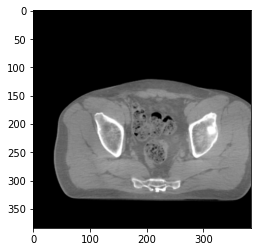

In [29]:
plt.imshow(x.squeeze(), 'gray'),

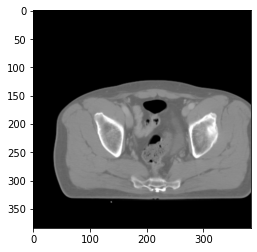

In [30]:
plt.imshow(y.squeeze(), 'gray')

In [31]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [32]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [33]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [34]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [35]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [38]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis = train_a2b_epoch(model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer,
                                                                                             edge_discriminator, edge_dis_optimizer,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_cont_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

84it [00:25,  3.28it/s]
84it [00:33,  2.52it/s]
84it [00:25,  3.32it/s]
12it [00:03,  3.80it/s]
84it [00:25,  3.35it/s]
84it [00:33,  2.54it/s]
84it [00:25,  3.33it/s]
12it [00:03,  3.80it/s]
84it [00:24,  3.43it/s]
84it [00:33,  2.49it/s]
84it [00:25,  3.33it/s]
12it [00:03,  3.80it/s]
84it [00:24,  3.39it/s]
84it [00:33,  2.50it/s]
84it [00:25,  3.32it/s]
12it [00:03,  3.81it/s]
84it [00:24,  3.41it/s]
84it [00:33,  2.50it/s]
84it [00:25,  3.31it/s]
12it [00:03,  3.83it/s]
84it [00:24,  3.45it/s]
84it [00:33,  2.51it/s]
84it [00:25,  3.33it/s]
12it [00:03,  3.79it/s]
84it [00:24,  3.41it/s]
84it [00:33,  2.51it/s]
84it [00:25,  3.32it/s]
12it [00:03,  3.82it/s]
84it [00:24,  3.40it/s]
84it [00:33,  2.51it/s]
84it [00:25,  3.32it/s]
12it [00:03,  3.75it/s]
84it [00:24,  3.41it/s]
84it [00:33,  2.49it/s]
84it [00:25,  3.29it/s]
12it [00:03,  3.79it/s]
84it [00:24,  3.38it/s]
84it [00:33,  2.50it/s]
84it [00:25,  3.31it/s]
12it [00:03,  3.81it/s]
84it [00:24,  3.41it/s]
84it [00:33,  2.

In [39]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [40]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [41]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.834244966506958
psnr score = 22.20571517944336
snr score = 12.268651962280273
mae error = 0.03148365020751953
air dice score = 0.995941415210874
bone dice score = 0.9384101941756916
contour dice score = 0.7494033575057983


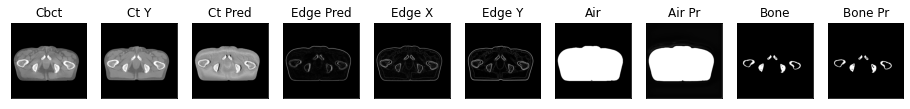

1it [00:00,  2.16it/s]

ssim score = 0.8359887003898621
psnr score = 22.115381240844727
snr score = 12.225854873657227
mae error = 0.031772393733263016
air dice score = 0.9959442779051353
bone dice score = 0.9413357400730846
contour dice score = 0.7531380653381348


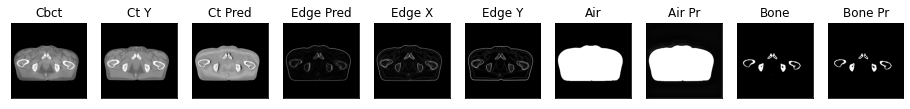

2it [00:01,  2.03it/s]

ssim score = 0.8365606069564819
psnr score = 22.099016189575195
snr score = 12.372384071350098
mae error = 0.03246596083045006
air dice score = 0.9962568836106411
bone dice score = 0.9153766769876758
contour dice score = 0.7772455215454102


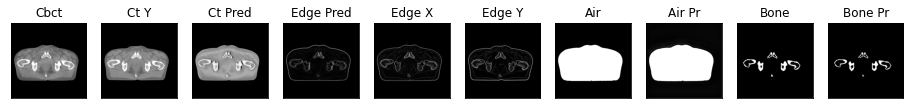

3it [00:01,  2.23it/s]

ssim score = 0.8350008130073547
psnr score = 22.16687774658203
snr score = 12.529497146606445
mae error = 0.03305519372224808
air dice score = 0.9957380784036494
bone dice score = 0.8877526753877792
contour dice score = 0.736652672290802


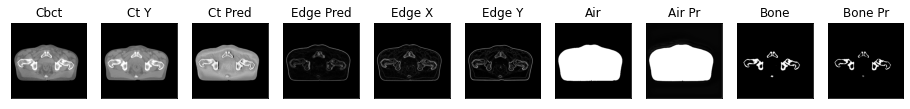

4it [00:01,  2.38it/s]

ssim score = 0.8355979919433594
psnr score = 22.34941864013672
snr score = 12.752342224121094
mae error = 0.03267962485551834
air dice score = 0.9952331238796903
bone dice score = 0.8619484491059201
contour dice score = 0.6903187036514282


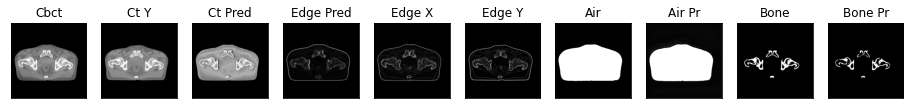

5it [00:02,  2.50it/s]

ssim score = 0.8312240839004517
psnr score = 22.326372146606445
snr score = 12.865829467773438
mae error = 0.03285173699259758
air dice score = 0.995270791697177
bone dice score = 0.8106280193255012
contour dice score = 0.6899879574775696


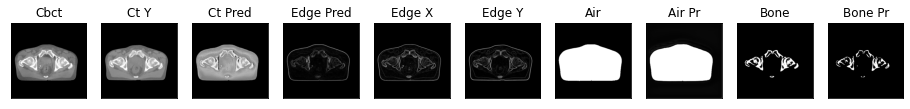

6it [00:02,  2.59it/s]

ssim score = 0.8276706337928772
psnr score = 22.022151947021484
snr score = 12.537554740905762
mae error = 0.033646680414676666
air dice score = 0.994963369963375
bone dice score = 0.7978973059251113
contour dice score = 0.6884058117866516


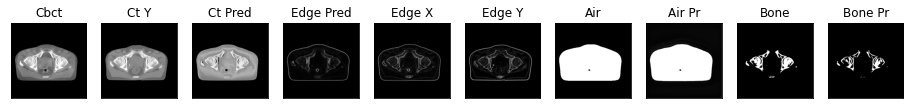

7it [00:02,  2.66it/s]

ssim score = 0.8363178372383118
psnr score = 22.207019805908203
snr score = 12.536886215209961
mae error = 0.032991498708724976
air dice score = 0.9952437693378373
bone dice score = 0.8484788228291064
contour dice score = 0.7228623628616333


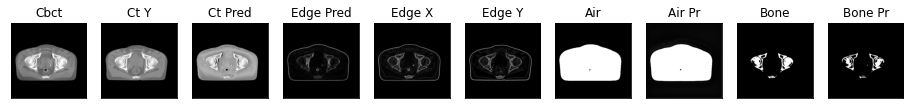

8it [00:03,  2.72it/s]

ssim score = 0.8450932502746582
psnr score = 22.348920822143555
snr score = 12.584230422973633
mae error = 0.03229028359055519
air dice score = 0.9957991235581567
bone dice score = 0.8952797749307567
contour dice score = 0.7846715450286865


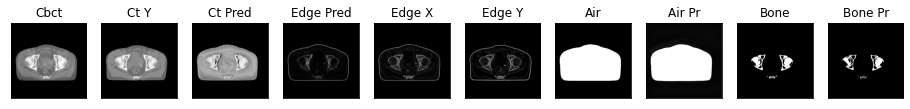

9it [00:03,  2.74it/s]

ssim score = 0.8462468981742859
psnr score = 22.345195770263672
snr score = 12.565221786499023
mae error = 0.031948793679475784
air dice score = 0.9953264869577606
bone dice score = 0.8920392584526494
contour dice score = 0.7536585330963135


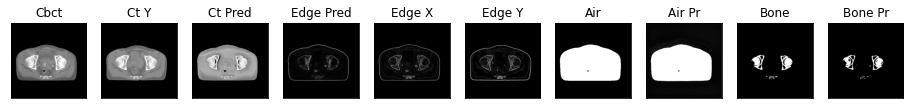

10it [00:03,  2.77it/s]

ssim score = 0.8528574705123901
psnr score = 22.560155868530273
snr score = 12.81245231628418
mae error = 0.030743492767214775
air dice score = 0.9962358077711736
bone dice score = 0.9170831440263847
contour dice score = 0.7704517841339111


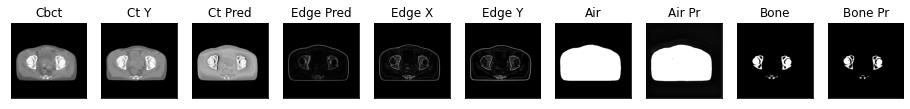

11it [00:04,  2.79it/s]

ssim score = 0.8535887002944946
psnr score = 22.348777770996094
snr score = 12.624786376953125
mae error = 0.031278226524591446
air dice score = 0.9953733757869946
bone dice score = 0.9075476026622212
contour dice score = 0.7779816389083862


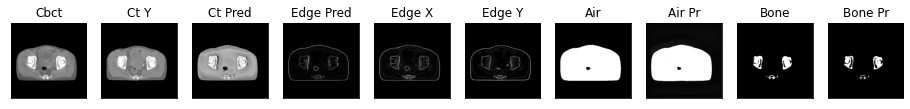

12it [00:04,  2.41it/s]

ssim score = 0.8565057516098022
psnr score = 22.045387268066406
snr score = 12.289471626281738
mae error = 0.03169410303235054
air dice score = 0.9953626027782747
bone dice score = 0.9309721720282981
contour dice score = 0.7581139206886292


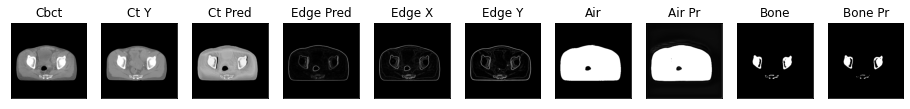

13it [00:05,  2.52it/s]

ssim score = 0.8538920283317566
psnr score = 22.007131576538086
snr score = 12.109258651733398
mae error = 0.031100954860448837
air dice score = 0.9946554385375488
bone dice score = 0.9139387539610092
contour dice score = 0.6666666865348816


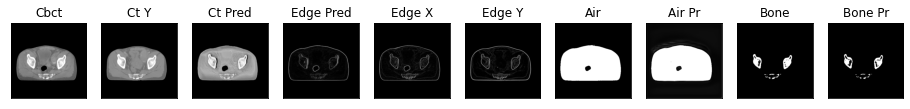

14it [00:05,  2.63it/s]

ssim score = 0.8522086143493652
psnr score = 21.995527267456055
snr score = 12.011993408203125
mae error = 0.030884040519595146
air dice score = 0.9939415688592481
bone dice score = 0.919944598339059
contour dice score = 0.5832305550575256


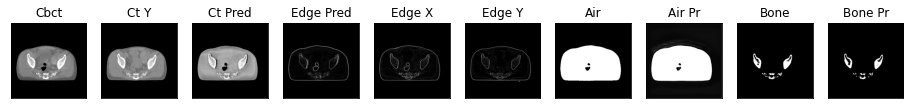

15it [00:05,  2.69it/s]

ssim score = 0.8473546504974365
psnr score = 21.87685203552246
snr score = 11.916803359985352
mae error = 0.03147951513528824
air dice score = 0.9934182590233616
bone dice score = 0.9080936454861793
contour dice score = 0.5957446694374084


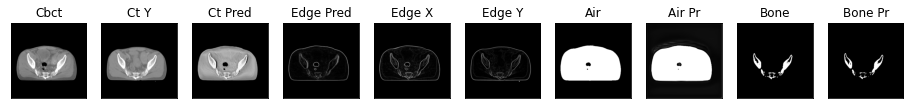

16it [00:06,  2.73it/s]

ssim score = 0.8472620844841003
psnr score = 21.543188095092773
snr score = 11.580595970153809
mae error = 0.03286433964967728
air dice score = 0.9922337595469062
bone dice score = 0.9056507936519917
contour dice score = 0.5448838472366333


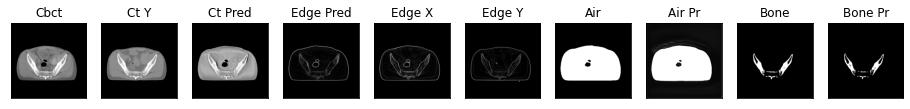

17it [00:06,  2.78it/s]

ssim score = 0.8415690660476685
psnr score = 21.244373321533203
snr score = 11.180020332336426
mae error = 0.03373061865568161
air dice score = 0.9901523677603777
bone dice score = 0.8911917098459691
contour dice score = 0.5185643434524536


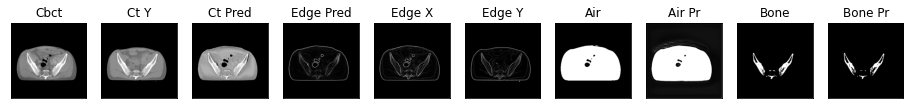

18it [00:06,  2.81it/s]

ssim score = 0.8388693332672119
psnr score = 21.107986450195312
snr score = 10.992951393127441
mae error = 0.03422097489237785
air dice score = 0.9886879552308804
bone dice score = 0.884289020315193
contour dice score = 0.5050890445709229


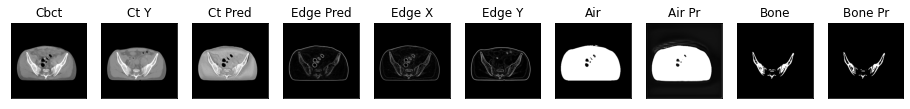

19it [00:07,  2.83it/s]

ssim score = 0.8433411121368408
psnr score = 21.144718170166016
snr score = 11.017375946044922
mae error = 0.033712975680828094
air dice score = 0.9896837143013871
bone dice score = 0.8928287906867844
contour dice score = 0.49588868021965027


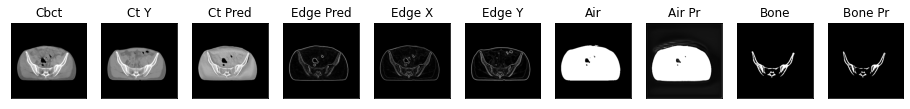

20it [00:07,  2.85it/s]

ssim score = 0.8397133946418762
psnr score = 21.03886604309082
snr score = 10.84667682647705
mae error = 0.03372206538915634
air dice score = 0.9898366566028667
bone dice score = 0.8900880431711149
contour dice score = 0.4917197525501251


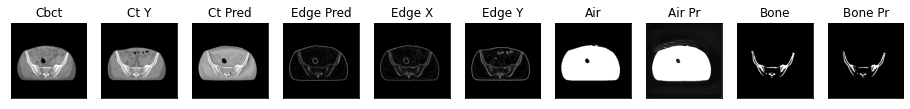

21it [00:08,  2.44it/s]

ssim score = 0.836467981338501
psnr score = 21.160778045654297
snr score = 10.909157752990723
mae error = 0.03314778581261635
air dice score = 0.9880391285015695
bone dice score = 0.8972612261935595
contour dice score = 0.48076921701431274


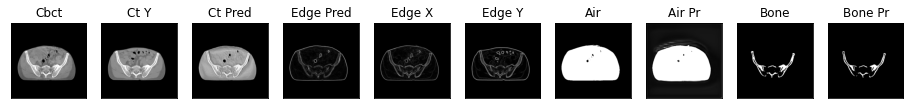

22it [00:08,  2.56it/s]

ssim score = 0.8436532020568848
psnr score = 21.11284065246582
snr score = 10.82779312133789
mae error = 0.03320881724357605
air dice score = 0.9881479815585426
bone dice score = 0.8954598979472006
contour dice score = 0.4385510981082916


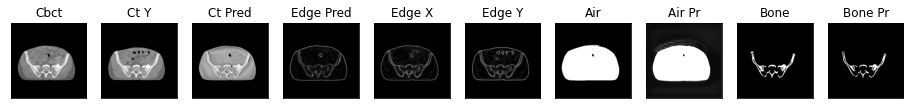

23it [00:08,  2.64it/s]

ssim score = 0.8433205485343933
psnr score = 20.990095138549805
snr score = 10.656481742858887
mae error = 0.033776722848415375
air dice score = 0.9872066538997754
bone dice score = 0.8967432466561885
contour dice score = 0.4674127697944641


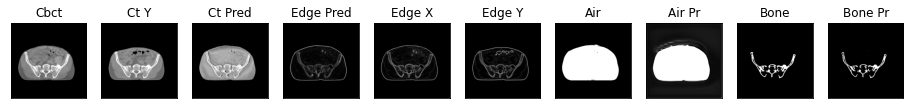

24it [00:09,  2.70it/s]

ssim score = 0.8462832570075989
psnr score = 20.885704040527344
snr score = 10.455089569091797
mae error = 0.0337824821472168
air dice score = 0.983788982003041
bone dice score = 0.8863803680995536
contour dice score = 0.4943219721317291


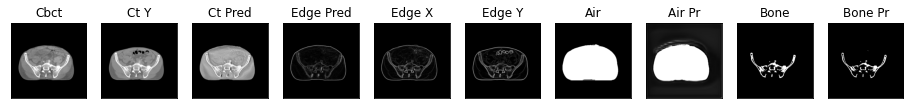

25it [00:09,  2.75it/s]

ssim score = 0.8483759760856628
psnr score = 20.897424697875977
snr score = 10.384077072143555
mae error = 0.03429553285241127
air dice score = 0.9817855100874181
bone dice score = 0.8774810095579824
contour dice score = 0.5335139036178589


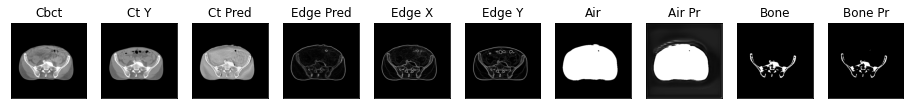

26it [00:09,  2.78it/s]

ssim score = 0.8456660509109497
psnr score = 20.883182525634766
snr score = 10.27864933013916
mae error = 0.034784816205501556
air dice score = 0.9765616664098252
bone dice score = 0.8788496105466883
contour dice score = 0.4498269855976105


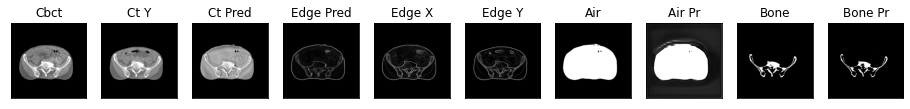

27it [00:10,  2.81it/s]

ssim score = 0.8458384871482849
psnr score = 20.638267517089844
snr score = 9.992626190185547
mae error = 0.035094745457172394
air dice score = 0.9703408058888553
bone dice score = 0.8824737562770141
contour dice score = 0.38035088777542114


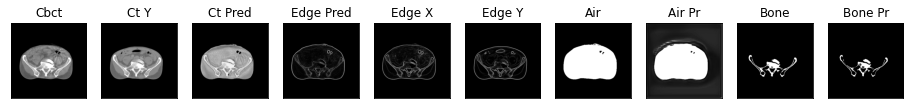

28it [00:10,  2.83it/s]

ssim score = 0.8143219947814941
psnr score = 21.413480758666992
snr score = 12.785639762878418
mae error = 0.04190995916724205
air dice score = 0.9958913023270252
bone dice score = 0.9690914767415207
contour dice score = 0.20382165908813477


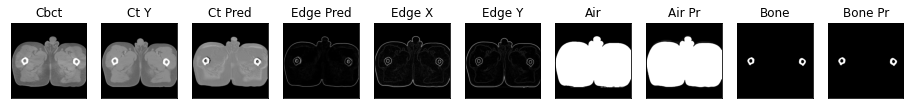

29it [00:10,  2.84it/s]

ssim score = 0.8225699663162231
psnr score = 21.84161949157715
snr score = 13.253032684326172
mae error = 0.04074365645647049
air dice score = 0.9952564173370918
bone dice score = 0.9739994157179667
contour dice score = 0.18734177947044373


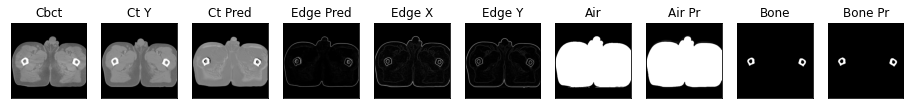

30it [00:11,  2.84it/s]

ssim score = 0.8275585770606995
psnr score = 22.212894439697266
snr score = 13.711756706237793
mae error = 0.04027844965457916
air dice score = 0.9954171491254827
bone dice score = 0.9680092059846258
contour dice score = 0.18028418719768524


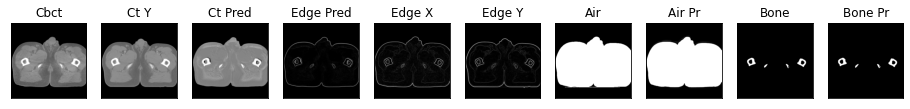

31it [00:11,  2.43it/s]

ssim score = 0.8292005658149719
psnr score = 22.49239158630371
snr score = 14.153813362121582
mae error = 0.039893828332424164
air dice score = 0.9964256721553825
bone dice score = 0.9686555290378893
contour dice score = 0.17203311622142792


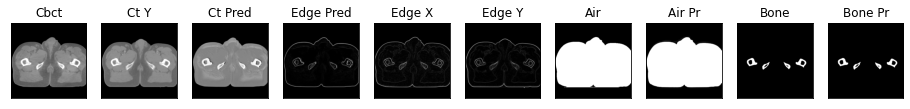

32it [00:12,  2.54it/s]

ssim score = 0.828495979309082
psnr score = 22.736621856689453
snr score = 14.52618408203125
mae error = 0.038981251418590546
air dice score = 0.9966473305273842
bone dice score = 0.9605336297948787
contour dice score = 0.17775709927082062


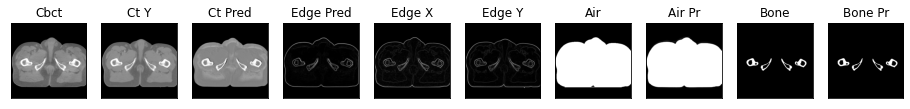

33it [00:12,  2.63it/s]

ssim score = 0.8294355273246765
psnr score = 22.86241340637207
snr score = 14.75521469116211
mae error = 0.0387376993894577
air dice score = 0.996762159921669
bone dice score = 0.945696342815593
contour dice score = 0.17427772283554077


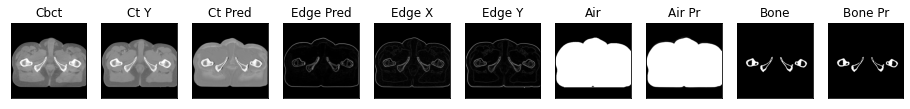

34it [00:12,  2.69it/s]

ssim score = 0.828478217124939
psnr score = 22.96450424194336
snr score = 14.924407005310059
mae error = 0.03910134732723236
air dice score = 0.9964687574814481
bone dice score = 0.9384950177535392
contour dice score = 0.16495805978775024


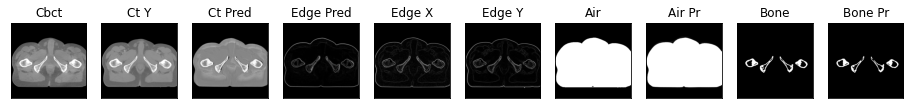

35it [00:13,  2.74it/s]

ssim score = 0.8268871307373047
psnr score = 22.99205780029297
snr score = 14.942071914672852
mae error = 0.03908418491482735
air dice score = 0.9964487152705265
bone dice score = 0.9430366038559342
contour dice score = 0.17759181559085846


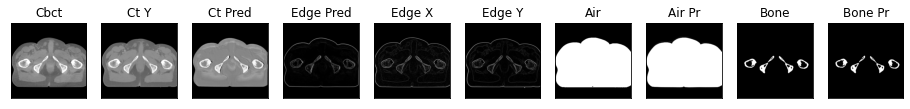

36it [00:13,  2.78it/s]

ssim score = 0.8280196189880371
psnr score = 23.15810203552246
snr score = 15.094450950622559
mae error = 0.03842168301343918
air dice score = 0.9963366035847696
bone dice score = 0.9459719696164975
contour dice score = 0.16286644339561462


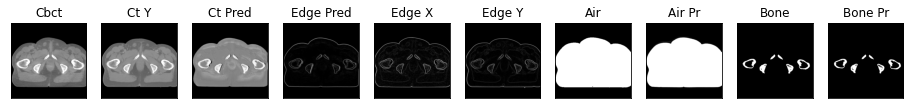

37it [00:13,  2.79it/s]

ssim score = 0.8342891335487366
psnr score = 23.46086311340332
snr score = 15.409212112426758
mae error = 0.0376596637070179
air dice score = 0.9966393252478889
bone dice score = 0.9489645807406477
contour dice score = 0.16565844416618347


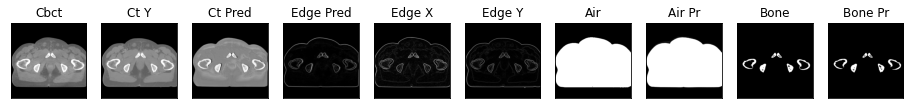

38it [00:14,  2.81it/s]

ssim score = 0.8352251052856445
psnr score = 23.586339950561523
snr score = 15.573773384094238
mae error = 0.03707723692059517
air dice score = 0.9966349583828795
bone dice score = 0.9425876324683522
contour dice score = 0.16339869797229767


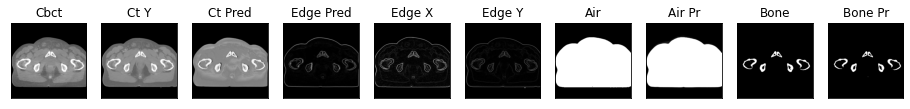

39it [00:14,  2.83it/s]

ssim score = 0.8290284276008606
psnr score = 23.38865089416504
snr score = 15.517375946044922
mae error = 0.03742211312055588
air dice score = 0.9966042022254092
bone dice score = 0.9193663771086421
contour dice score = 0.16198502480983734


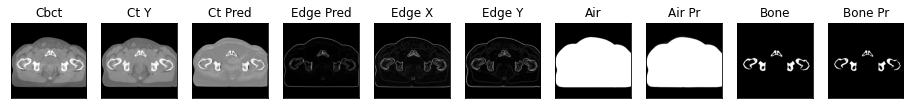

40it [00:14,  2.84it/s]

ssim score = 0.8269495964050293
psnr score = 23.348386764526367
snr score = 15.571795463562012
mae error = 0.037873368710279465
air dice score = 0.9963792282039088
bone dice score = 0.8874923627486472
contour dice score = 0.16776007413864136


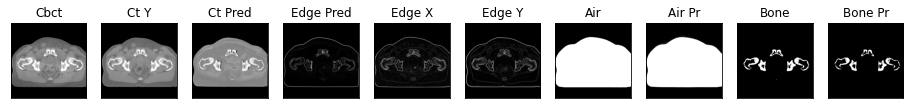

41it [00:15,  2.43it/s]

ssim score = 0.8166723251342773
psnr score = 22.788246154785156
snr score = 14.977607727050781
mae error = 0.03935377299785614
air dice score = 0.9963854054021781
bone dice score = 0.8548849326977431
contour dice score = 0.1918194591999054


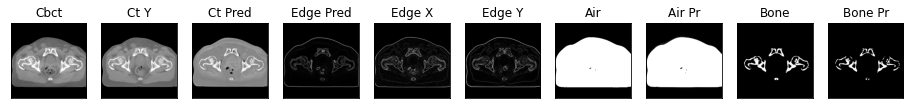

42it [00:15,  2.54it/s]

ssim score = 0.8162242770195007
psnr score = 22.026695251464844
snr score = 14.288246154785156
mae error = 0.04186852648854256
air dice score = 0.9954711397932269
bone dice score = 0.7894941937511535
contour dice score = 0.18747055530548096


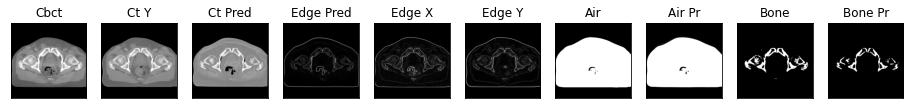

43it [00:16,  2.62it/s]

ssim score = 0.8173502683639526
psnr score = 22.24164581298828
snr score = 14.36709976196289
mae error = 0.040232330560684204
air dice score = 0.996205380035113
bone dice score = 0.845083932855203
contour dice score = 0.1983002871274948


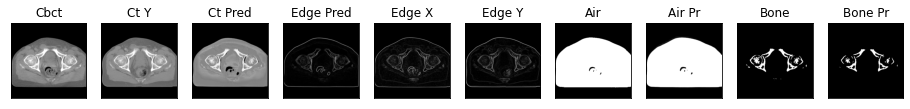

44it [00:16,  2.68it/s]

ssim score = 0.8236241340637207
psnr score = 22.460559844970703
snr score = 14.407454490661621
mae error = 0.03856837749481201
air dice score = 0.9967776064810636
bone dice score = 0.8868156653692145
contour dice score = 0.20748460292816162


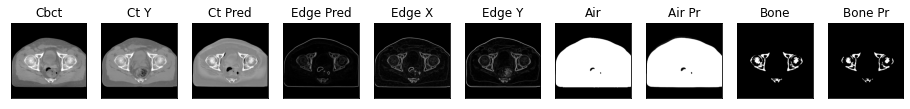

45it [00:16,  2.73it/s]

ssim score = 0.8207115530967712
psnr score = 22.446928024291992
snr score = 14.303234100341797
mae error = 0.039034098386764526
air dice score = 0.9970942551001895
bone dice score = 0.8986524742396256
contour dice score = 0.21258340775966644


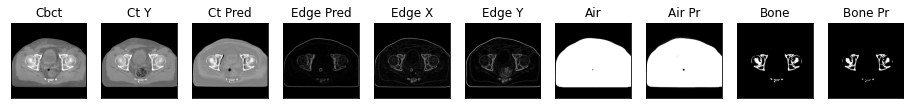

46it [00:17,  2.77it/s]

ssim score = 0.8240605592727661
psnr score = 22.541996002197266
snr score = 14.41398811340332
mae error = 0.038738083094358444
air dice score = 0.9972089289949121
bone dice score = 0.9041008116199903
contour dice score = 0.22688274085521698


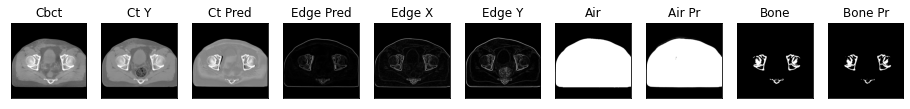

47it [00:17,  2.80it/s]

ssim score = 0.8120740652084351
psnr score = 22.2960205078125
snr score = 14.178054809570312
mae error = 0.04043523594737053
air dice score = 0.9971638141809308
bone dice score = 0.9041440743618886
contour dice score = 0.22169135510921478


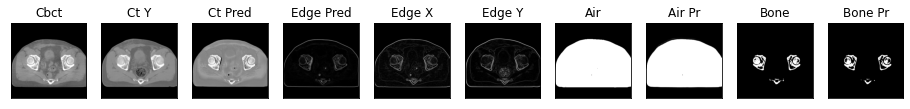

48it [00:17,  2.81it/s]

ssim score = 0.8175941705703735
psnr score = 22.295459747314453
snr score = 14.239081382751465
mae error = 0.04085250198841095
air dice score = 0.9969758868380554
bone dice score = 0.8936581593204402
contour dice score = 0.22529833018779755


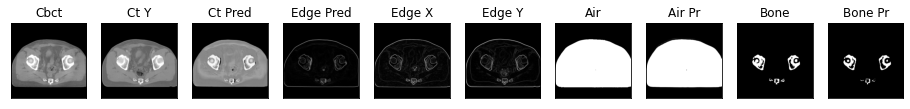

49it [00:18,  2.80it/s]

ssim score = 0.8234103918075562
psnr score = 22.699913024902344
snr score = 14.713616371154785
mae error = 0.039954740554094315
air dice score = 0.9964331836910421
bone dice score = 0.9202590194271947
contour dice score = 0.20495709776878357


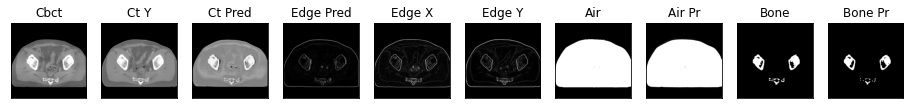

50it [00:18,  2.42it/s]

ssim score = 0.8291083574295044
psnr score = 22.798622131347656
snr score = 14.693217277526855
mae error = 0.03841489553451538
air dice score = 0.9968217278243302
bone dice score = 0.9209853828077176
contour dice score = 0.20219360291957855


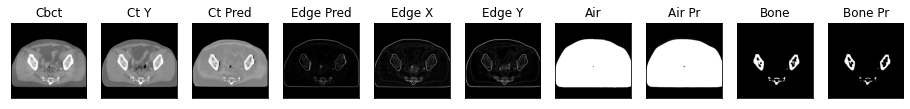

51it [00:19,  2.54it/s]

ssim score = 0.8216426968574524
psnr score = 22.113401412963867
snr score = 14.089624404907227
mae error = 0.04183153808116913
air dice score = 0.9963191239637957
bone dice score = 0.9088123986312056
contour dice score = 0.1793764978647232


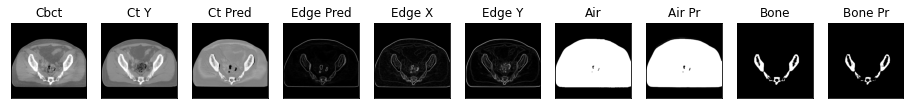

52it [00:19,  2.63it/s]

ssim score = 0.8220493793487549
psnr score = 22.11544418334961
snr score = 14.171817779541016
mae error = 0.04254923760890961
air dice score = 0.9953240632785586
bone dice score = 0.8680278494886331
contour dice score = 0.17587697505950928


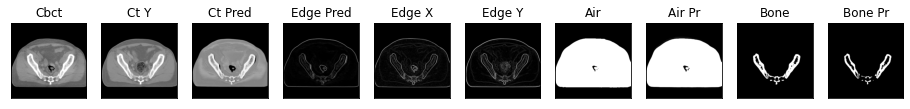

53it [00:19,  2.69it/s]

ssim score = 0.8059077262878418
psnr score = 21.850767135620117
snr score = 13.928694725036621
mae error = 0.04351402446627617
air dice score = 0.9958262955619227
bone dice score = 0.8570071258918686
contour dice score = 0.15154440701007843


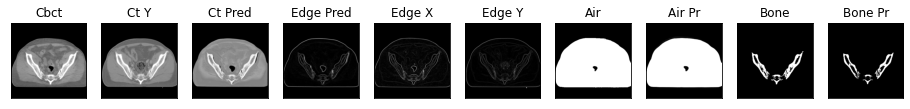

54it [00:20,  2.73it/s]

ssim score = 0.8139945864677429
psnr score = 22.29706573486328
snr score = 14.387532234191895
mae error = 0.04188602790236473
air dice score = 0.995757336651394
bone dice score = 0.8687141947814393
contour dice score = 0.12915661931037903


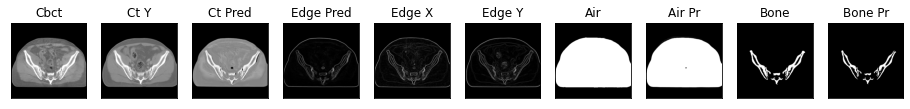

55it [00:20,  2.74it/s]

ssim score = 0.7759618759155273
psnr score = 18.887346267700195
snr score = 8.767556190490723
mae error = 0.045200347900390625
air dice score = 0.9969757255136387
bone dice score = 0.948752347734136
contour dice score = 0.5847176313400269


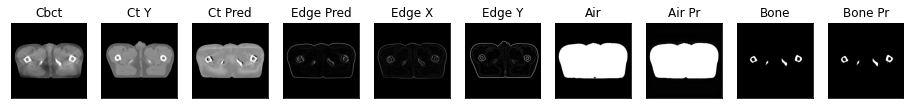

56it [00:20,  2.77it/s]

ssim score = 0.7724577784538269
psnr score = 18.936614990234375
snr score = 9.029804229736328
mae error = 0.04549924284219742
air dice score = 0.9970017918285549
bone dice score = 0.933670246369053
contour dice score = 0.5876516103744507


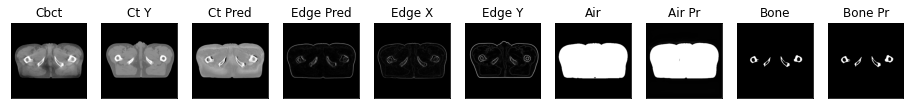

57it [00:21,  2.81it/s]

ssim score = 0.7690553069114685
psnr score = 19.028316497802734
snr score = 9.252643585205078
mae error = 0.04537420719861984
air dice score = 0.9971416976904237
bone dice score = 0.9149479473597535
contour dice score = 0.5875892639160156


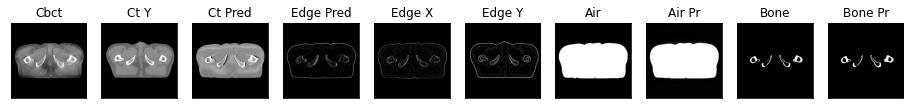

58it [00:21,  2.83it/s]

ssim score = 0.7716180682182312
psnr score = 19.275318145751953
snr score = 9.570046424865723
mae error = 0.044252458959817886
air dice score = 0.9967669384312652
bone dice score = 0.9110105580710594
contour dice score = 0.530992865562439


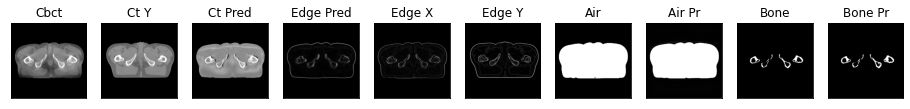

59it [00:21,  2.84it/s]

ssim score = 0.7746036648750305
psnr score = 19.37836456298828
snr score = 9.720661163330078
mae error = 0.04386572167277336
air dice score = 0.9964016494628771
bone dice score = 0.917157584684883
contour dice score = 0.48471614718437195


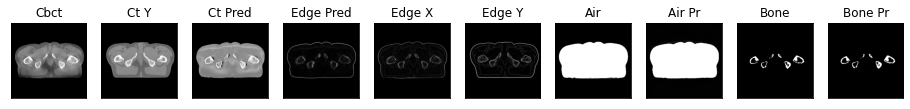

60it [00:22,  2.44it/s]

ssim score = 0.7746212482452393
psnr score = 19.424964904785156
snr score = 9.772876739501953
mae error = 0.04353471100330353
air dice score = 0.9959155888359463
bone dice score = 0.9248868778294138
contour dice score = 0.5369484424591064


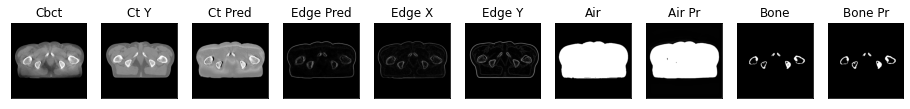

61it [00:22,  2.55it/s]

ssim score = 0.7756562829017639
psnr score = 19.382509231567383
snr score = 9.723918914794922
mae error = 0.043643444776535034
air dice score = 0.9951961569255446
bone dice score = 0.9230483271389768
contour dice score = 0.5330490469932556


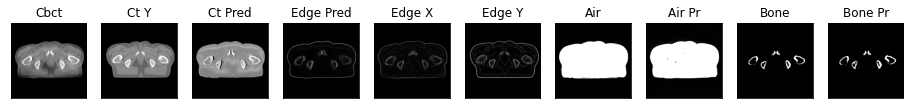

62it [00:23,  2.64it/s]

ssim score = 0.7760522365570068
psnr score = 19.303455352783203
snr score = 9.658974647521973
mae error = 0.04380864277482033
air dice score = 0.9957510275576249
bone dice score = 0.9269188395165825
contour dice score = 0.4960085153579712


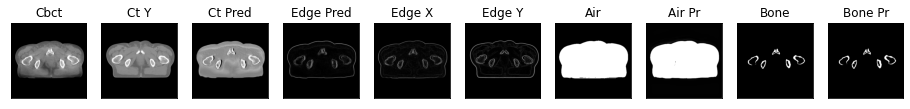

63it [00:23,  2.71it/s]

ssim score = 0.7765580415725708
psnr score = 19.391098022460938
snr score = 9.804624557495117
mae error = 0.043864235281944275
air dice score = 0.9958061106008389
bone dice score = 0.924172185431719
contour dice score = 0.498395711183548


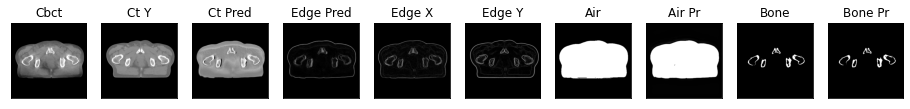

64it [00:23,  2.75it/s]

ssim score = 0.7682801485061646
psnr score = 19.28786277770996
snr score = 9.79995059967041
mae error = 0.04535014182329178
air dice score = 0.9954201375687018
bone dice score = 0.9081962171319669
contour dice score = 0.4486772418022156


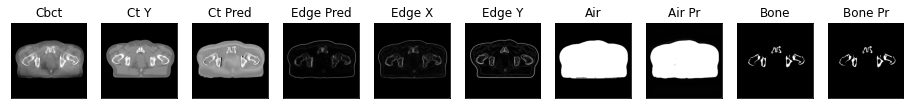

65it [00:24,  2.79it/s]

ssim score = 0.7577683925628662
psnr score = 19.19999885559082
snr score = 9.747912406921387
mae error = 0.04660119488835335
air dice score = 0.9956008694752134
bone dice score = 0.90737126557713
contour dice score = 0.42580646276474


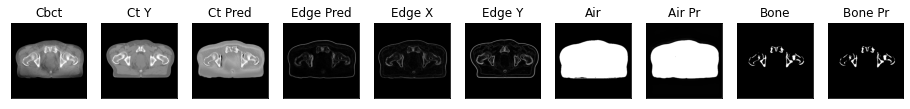

66it [00:24,  2.82it/s]

ssim score = 0.7454416751861572
psnr score = 19.042781829833984
snr score = 9.623404502868652
mae error = 0.04788928106427193
air dice score = 0.9963372488860959
bone dice score = 0.8748080949075393
contour dice score = 0.46277451515197754


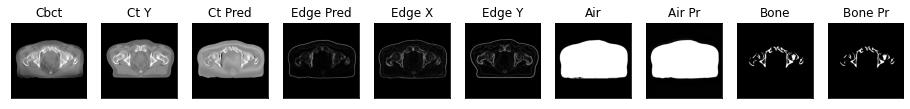

67it [00:24,  2.82it/s]

ssim score = 0.7497555613517761
psnr score = 18.997447967529297
snr score = 9.694887161254883
mae error = 0.04847912862896919
air dice score = 0.9967867265099398
bone dice score = 0.9054463932493018
contour dice score = 0.520866334438324


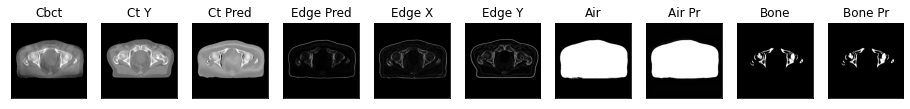

68it [00:25,  2.84it/s]

ssim score = 0.7511675953865051
psnr score = 18.84954833984375
snr score = 9.531000137329102
mae error = 0.049373455345630646
air dice score = 0.9965980828689818
bone dice score = 0.8916347109800933
contour dice score = 0.5457516312599182


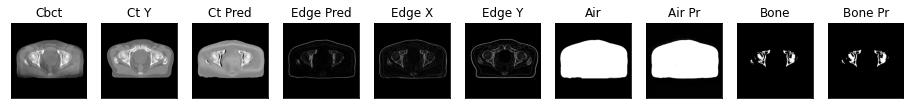

69it [00:25,  2.45it/s]

ssim score = 0.7667812705039978
psnr score = 19.269691467285156
snr score = 9.751978874206543
mae error = 0.046603888273239136
air dice score = 0.9962154444272452
bone dice score = 0.9131288714320421
contour dice score = 0.5397849678993225


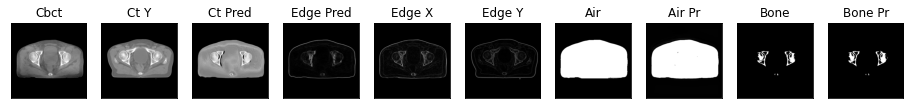

70it [00:26,  2.56it/s]

ssim score = 0.7828420996665955
psnr score = 19.716245651245117
snr score = 10.028141021728516
mae error = 0.04414929822087288
air dice score = 0.9962712213897894
bone dice score = 0.942127659575289
contour dice score = 0.49919137358665466


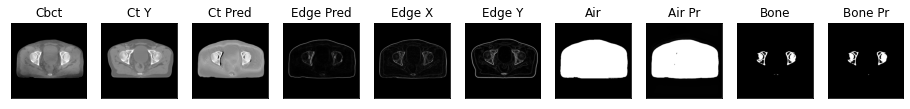

71it [00:26,  2.63it/s]

ssim score = 0.7869733572006226
psnr score = 19.988983154296875
snr score = 10.315047264099121
mae error = 0.04297438636422157
air dice score = 0.9958492701919319
bone dice score = 0.9460704607053378
contour dice score = 0.4903640151023865


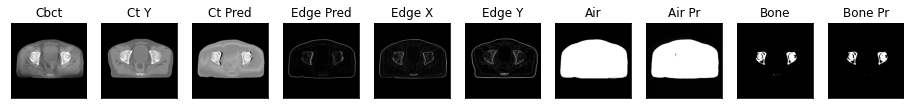

72it [00:26,  2.70it/s]

ssim score = 0.7869722843170166
psnr score = 20.175722122192383
snr score = 10.583614349365234
mae error = 0.04254293441772461
air dice score = 0.9960876302339751
bone dice score = 0.9405511260324444
contour dice score = 0.4888647496700287


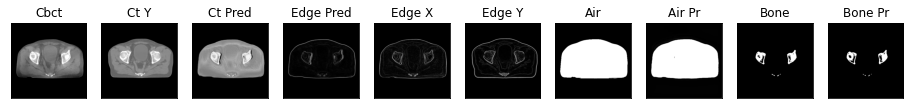

73it [00:27,  2.75it/s]

ssim score = 0.7865143418312073
psnr score = 20.03664207458496
snr score = 10.536707878112793
mae error = 0.042270321398973465
air dice score = 0.9962275101567066
bone dice score = 0.9402232074615469
contour dice score = 0.4958677589893341


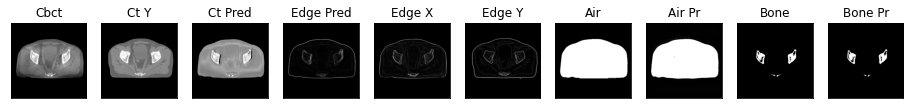

74it [00:27,  2.79it/s]

ssim score = 0.786060094833374
psnr score = 20.215511322021484
snr score = 10.652151107788086
mae error = 0.04108502343297005
air dice score = 0.9960309703300193
bone dice score = 0.958340248963347
contour dice score = 0.5276733040809631


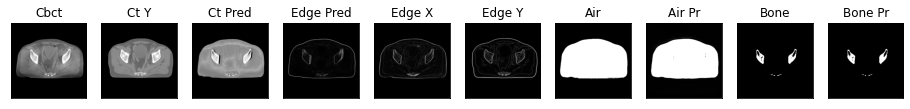

75it [00:27,  2.81it/s]

ssim score = 0.7875641584396362
psnr score = 20.374378204345703
snr score = 10.774625778198242
mae error = 0.040545884519815445
air dice score = 0.9954129998980705
bone dice score = 0.9517340007159146
contour dice score = 0.48772677779197693


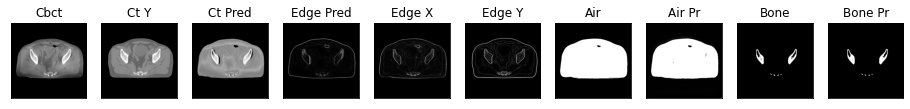

76it [00:28,  2.83it/s]

ssim score = 0.7840536832809448
psnr score = 20.23805809020996
snr score = 10.67604923248291
mae error = 0.042110517621040344
air dice score = 0.9952189678745254
bone dice score = 0.9347466048371191
contour dice score = 0.49814125895500183


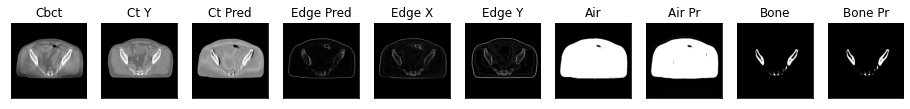

77it [00:28,  2.84it/s]

ssim score = 0.7835977077484131
psnr score = 20.308238983154297
snr score = 10.876733779907227
mae error = 0.04230957850813866
air dice score = 0.9957098317064712
bone dice score = 0.9284550436982898
contour dice score = 0.5165775418281555


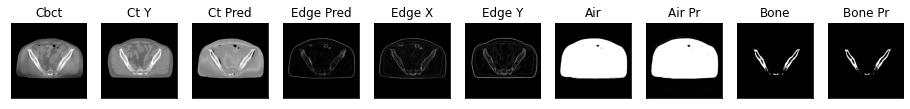

78it [00:28,  2.85it/s]

ssim score = 0.7818681597709656
psnr score = 20.345157623291016
snr score = 10.931401252746582
mae error = 0.0422980822622776
air dice score = 0.9961554526933175
bone dice score = 0.9056423334410959
contour dice score = 0.5419355034828186


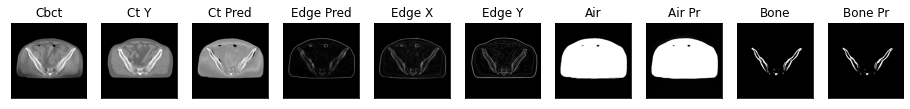

79it [00:29,  2.44it/s]

ssim score = 0.7828004956245422
psnr score = 20.546527862548828
snr score = 11.121503829956055
mae error = 0.04121449962258339
air dice score = 0.9958494150670547
bone dice score = 0.9091528890419439
contour dice score = 0.5215982794761658


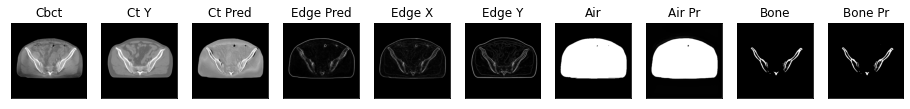

80it [00:29,  2.55it/s]

ssim score = 0.7856684923171997
psnr score = 20.733779907226562
snr score = 11.308015823364258
mae error = 0.040108371526002884
air dice score = 0.99581812717359
bone dice score = 0.9047306176099749
contour dice score = 0.5013623833656311


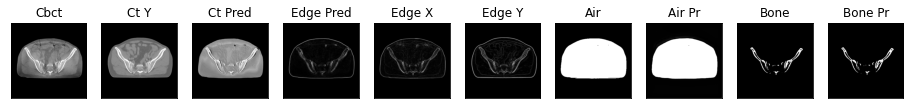

81it [00:30,  2.63it/s]

ssim score = 0.8128091096878052
psnr score = 20.931377410888672
snr score = 11.365510940551758
mae error = 0.04079755023121834
air dice score = 0.9962781430563887
bone dice score = 0.9124767225358482
contour dice score = 0.3910733163356781


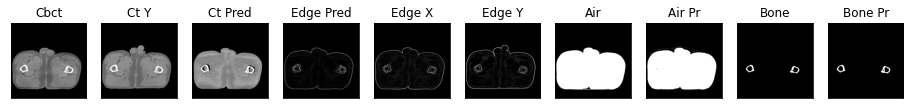

82it [00:30,  2.70it/s]

ssim score = 0.8129135370254517
psnr score = 21.21487808227539
snr score = 11.71340560913086
mae error = 0.03937552496790886
air dice score = 0.996486007344564
bone dice score = 0.8985604285269984
contour dice score = 0.3172268867492676


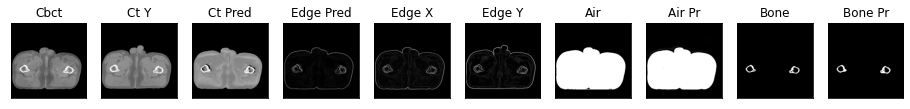

83it [00:30,  2.75it/s]

ssim score = 0.819389820098877
psnr score = 22.042428970336914
snr score = 12.680167198181152
mae error = 0.03661306947469711
air dice score = 0.9968628003223282
bone dice score = 0.9184118673665268
contour dice score = 0.3985764980316162


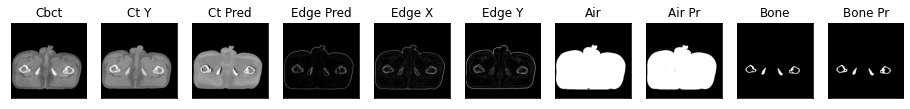

84it [00:31,  2.78it/s]

ssim score = 0.8216215968132019
psnr score = 22.14443016052246
snr score = 12.903660774230957
mae error = 0.03559926152229309
air dice score = 0.9970970277611335
bone dice score = 0.8971770039172228
contour dice score = 0.4267352223396301


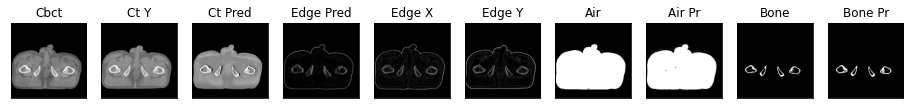

85it [00:31,  2.81it/s]

ssim score = 0.8192135095596313
psnr score = 22.08858299255371
snr score = 12.871986389160156
mae error = 0.03564860299229622
air dice score = 0.997632851366351
bone dice score = 0.8766220391374537
contour dice score = 0.4155440330505371


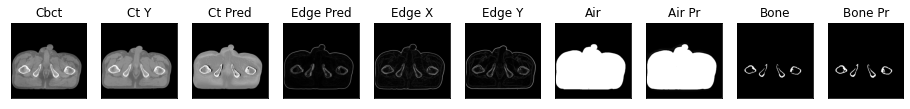

86it [00:31,  2.83it/s]

ssim score = 0.8156127333641052
psnr score = 21.886024475097656
snr score = 12.665031433105469
mae error = 0.03654949739575386
air dice score = 0.9978757055138638
bone dice score = 0.8748358040931725
contour dice score = 0.4173640310764313


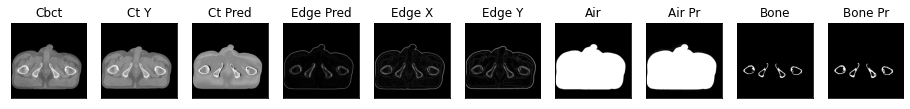

87it [00:32,  2.84it/s]

ssim score = 0.8175029754638672
psnr score = 21.551000595092773
snr score = 12.336262702941895
mae error = 0.03716954588890076
air dice score = 0.9971016738995683
bone dice score = 0.8903274942899785
contour dice score = 0.38906413316726685


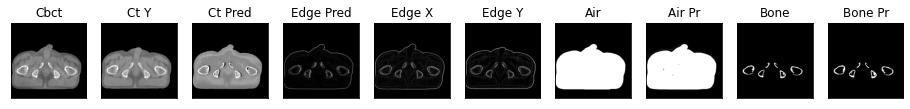

88it [00:32,  2.45it/s]

ssim score = 0.8165857195854187
psnr score = 21.398788452148438
snr score = 12.162492752075195
mae error = 0.0373140424489975
air dice score = 0.9974947451698241
bone dice score = 0.9046692607022437
contour dice score = 0.4027411639690399


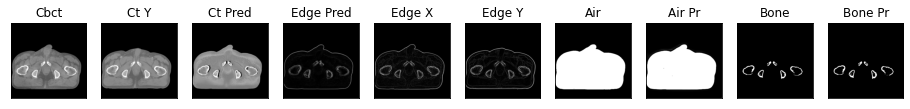

89it [00:33,  2.56it/s]

ssim score = 0.8181887269020081
psnr score = 21.397090911865234
snr score = 12.177704811096191
mae error = 0.03725113719701767
air dice score = 0.9972236263949938
bone dice score = 0.9217908229626269
contour dice score = 0.3515087366104126


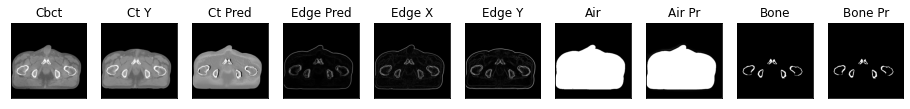

90it [00:33,  2.64it/s]

ssim score = 0.8196390271186829
psnr score = 21.684467315673828
snr score = 12.533675193786621
mae error = 0.036374252289533615
air dice score = 0.9970022951178028
bone dice score = 0.9197717354830518
contour dice score = 0.38527214527130127


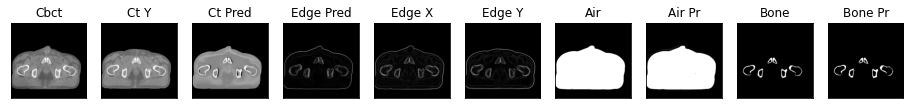

91it [00:33,  2.71it/s]

ssim score = 0.8197131752967834
psnr score = 21.999284744262695
snr score = 12.929854393005371
mae error = 0.03579467907547951
air dice score = 0.9968727221425405
bone dice score = 0.9173913043491089
contour dice score = 0.42603549361228943


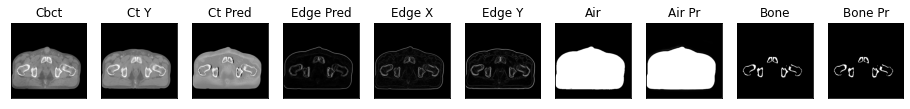

92it [00:34,  2.75it/s]

ssim score = 0.8193355202674866
psnr score = 22.249004364013672
snr score = 13.230274200439453
mae error = 0.03569057211279869
air dice score = 0.9968048603897152
bone dice score = 0.9065434490996193
contour dice score = 0.47337278723716736


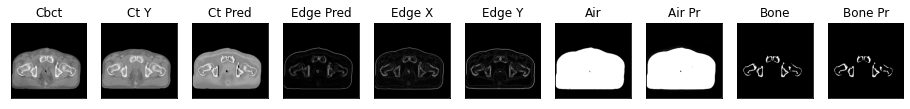

93it [00:34,  2.79it/s]

ssim score = 0.8245278000831604
psnr score = 22.472341537475586
snr score = 13.569879531860352
mae error = 0.03558732196688652
air dice score = 0.9971661548905558
bone dice score = 0.868782161236867
contour dice score = 0.452931672334671


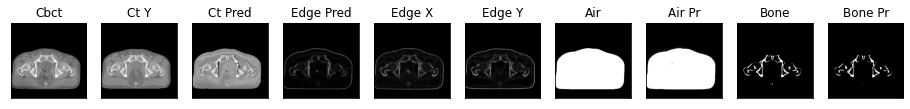

94it [00:34,  2.81it/s]

ssim score = 0.8236556053161621
psnr score = 22.42262077331543
snr score = 13.481924057006836
mae error = 0.035794127732515335
air dice score = 0.9975397215917228
bone dice score = 0.8766349583847112
contour dice score = 0.41141626238822937


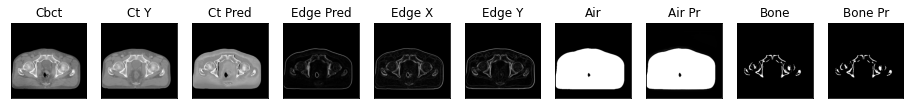

95it [00:35,  2.83it/s]

ssim score = 0.815546989440918
psnr score = 21.978282928466797
snr score = 12.941914558410645
mae error = 0.03766863793134689
air dice score = 0.9972064579647988
bone dice score = 0.8845736013052068
contour dice score = 0.4343598186969757


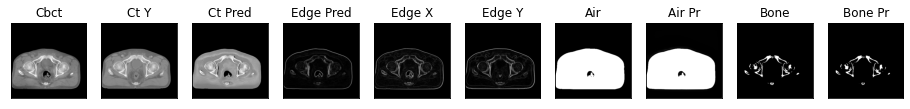

96it [00:35,  2.85it/s]

ssim score = 0.8190218806266785
psnr score = 21.5169620513916
snr score = 12.32083511352539
mae error = 0.03928384557366371
air dice score = 0.9966340269277872
bone dice score = 0.8658290677855464
contour dice score = 0.4935064911842346


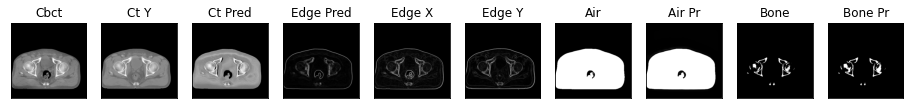

97it [00:36,  2.83it/s]

ssim score = 0.8170126676559448
psnr score = 21.182558059692383
snr score = 11.870010375976562
mae error = 0.04076700285077095
air dice score = 0.996507453208831
bone dice score = 0.8697883258519918
contour dice score = 0.490217387676239


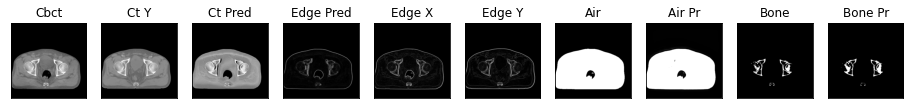

98it [00:36,  2.43it/s]

ssim score = 0.8189246654510498
psnr score = 21.047075271606445
snr score = 11.689428329467773
mae error = 0.04184214398264885
air dice score = 0.9970093488574099
bone dice score = 0.8970903522220967
contour dice score = 0.46296295523643494


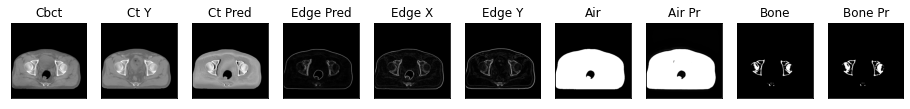

99it [00:36,  2.52it/s]

ssim score = 0.8159310221672058
psnr score = 20.772903442382812
snr score = 11.421930313110352
mae error = 0.042391058057546616
air dice score = 0.9971435606993375
bone dice score = 0.929235618598436
contour dice score = 0.4391043186187744


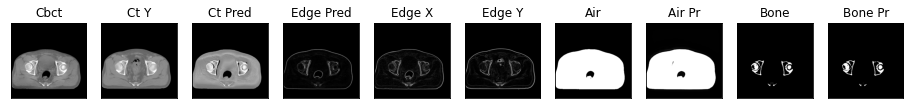

100it [00:37,  2.62it/s]

ssim score = 0.820432722568512
psnr score = 20.596267700195312
snr score = 11.275400161743164
mae error = 0.042441390454769135
air dice score = 0.9974330283683296
bone dice score = 0.9389136790284827
contour dice score = 0.4137931168079376


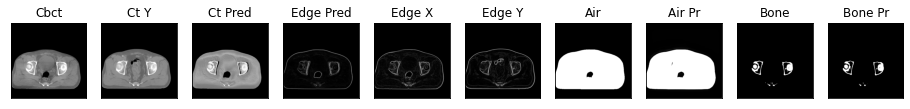

101it [00:37,  2.67it/s]

ssim score = 0.8225468397140503
psnr score = 20.934112548828125
snr score = 11.570655822753906
mae error = 0.04027964174747467
air dice score = 0.9971004969403284
bone dice score = 0.9311351537020242
contour dice score = 0.4107338488101959


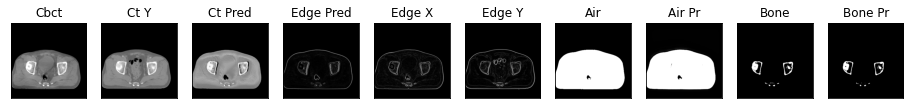

102it [00:37,  2.73it/s]

ssim score = 0.8207855224609375
psnr score = 20.853364944458008
snr score = 11.399703979492188
mae error = 0.04001137614250183
air dice score = 0.9970969551017739
bone dice score = 0.9164063935345139
contour dice score = 0.4284931421279907


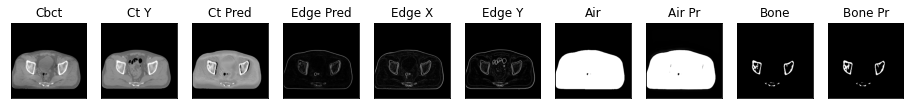

103it [00:38,  2.77it/s]

ssim score = 0.8202219009399414
psnr score = 20.612552642822266
snr score = 11.093168258666992
mae error = 0.04110529273748398
air dice score = 0.9969919925341446
bone dice score = 0.9328358208968414
contour dice score = 0.45334798097610474


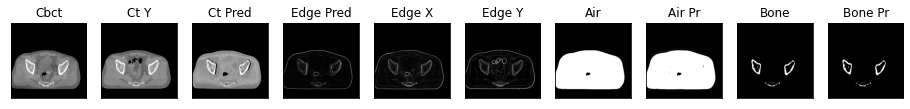

104it [00:38,  2.81it/s]

ssim score = 0.816898763179779
psnr score = 20.66468048095703
snr score = 11.144991874694824
mae error = 0.04069734364748001
air dice score = 0.9968870877069358
bone dice score = 0.9305167597777494
contour dice score = 0.47414740920066833


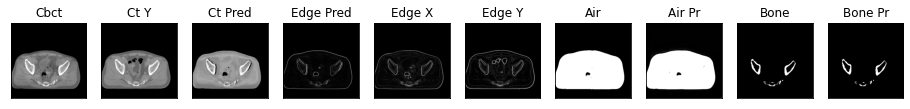

105it [00:39,  2.80it/s]

ssim score = 0.8130591511726379
psnr score = 20.61302947998047
snr score = 11.169509887695312
mae error = 0.04114893451333046
air dice score = 0.9964268780058284
bone dice score = 0.9232337946114605
contour dice score = 0.5273631811141968


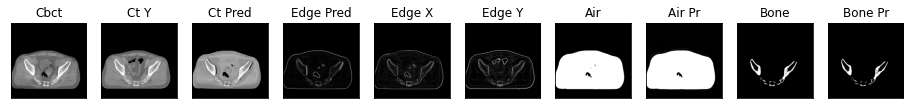

106it [00:39,  2.82it/s]

ssim score = 0.8200831413269043
psnr score = 20.809188842773438
snr score = 11.401248931884766
mae error = 0.04071541503071785
air dice score = 0.995969288191637
bone dice score = 0.9117891816933178
contour dice score = 0.5425414443016052


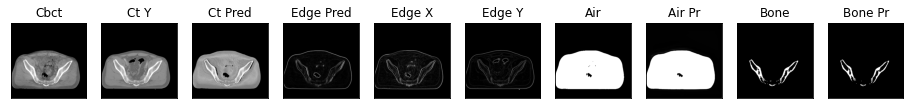

107it [00:39,  2.43it/s]

ssim score = 0.8187583088874817
psnr score = 21.210107803344727
snr score = 11.740470886230469
mae error = 0.039516691118478775
air dice score = 0.9961445535393032
bone dice score = 0.9031501831516022
contour dice score = 0.5662049651145935


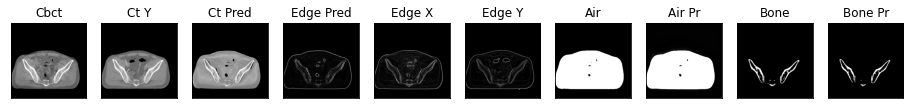

108it [00:40,  2.55it/s]

ssim score = 0.8171543478965759
psnr score = 21.187917709350586
snr score = 11.657020568847656
mae error = 0.03914203494787216
air dice score = 0.9963046744141905
bone dice score = 0.9072353389199203
contour dice score = 0.5257847309112549


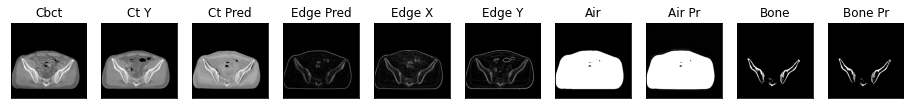

109it [00:40,  2.64it/s]

ssim score = 0.7811968922615051
psnr score = 20.75322723388672
snr score = 12.450531959533691
mae error = 0.043688494712114334
air dice score = 0.9965192744436493
bone dice score = 0.9622815087408071
contour dice score = 0.25


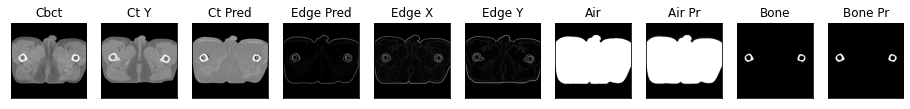

110it [00:40,  2.70it/s]

ssim score = 0.7734891176223755
psnr score = 20.71221351623535
snr score = 12.513809204101562
mae error = 0.04396314546465874
air dice score = 0.9965920213205053
bone dice score = 0.9510070767569132
contour dice score = 0.2624555230140686


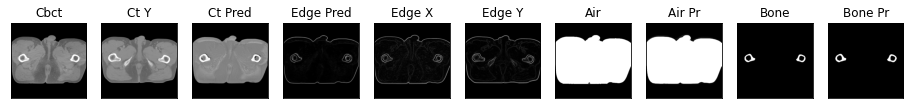

111it [00:41,  2.75it/s]

ssim score = 0.7680507302284241
psnr score = 20.63970947265625
snr score = 12.569263458251953
mae error = 0.04413257911801338
air dice score = 0.9965677746955683
bone dice score = 0.9260850880978495
contour dice score = 0.25224417448043823


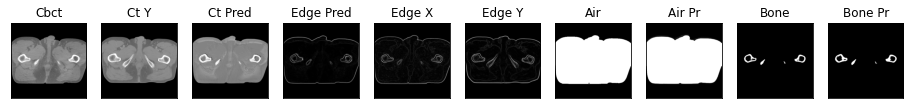

112it [00:41,  2.79it/s]

ssim score = 0.7607198357582092
psnr score = 20.28649139404297
snr score = 12.248333930969238
mae error = 0.04635225608944893
air dice score = 0.996336094452556
bone dice score = 0.9425175052932337
contour dice score = 0.23592975735664368


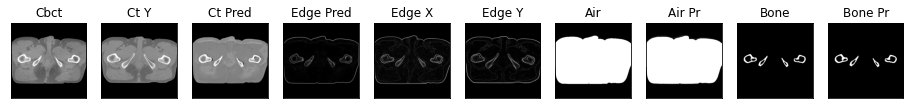

113it [00:42,  2.81it/s]

ssim score = 0.7506683468818665
psnr score = 20.09596061706543
snr score = 12.088041305541992
mae error = 0.04793534427881241
air dice score = 0.9965215052820524
bone dice score = 0.9140025575461317
contour dice score = 0.2312556505203247


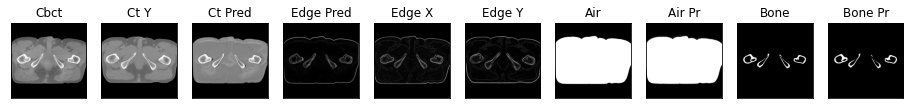

114it [00:42,  2.83it/s]

ssim score = 0.7467817068099976
psnr score = 19.97612190246582
snr score = 12.002618789672852
mae error = 0.04885141924023628
air dice score = 0.9966665501124767
bone dice score = 0.9229131823031335
contour dice score = 0.23209428787231445


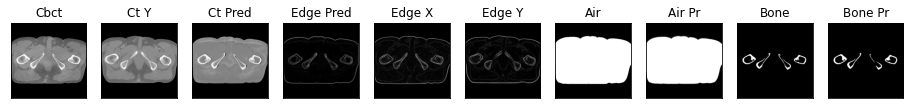

115it [00:42,  2.84it/s]

ssim score = 0.7380720973014832
psnr score = 19.671415328979492
snr score = 11.71822452545166
mae error = 0.050500836223363876
air dice score = 0.9964703287006418
bone dice score = 0.9307817589585942
contour dice score = 0.243792325258255


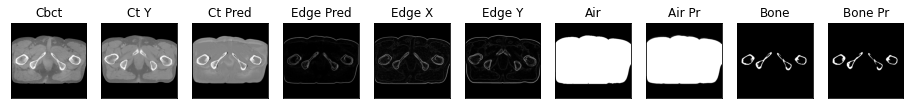

116it [00:43,  2.85it/s]

ssim score = 0.7384504675865173
psnr score = 19.585941314697266
snr score = 11.67182445526123
mae error = 0.05034511536359787
air dice score = 0.996087659609
bone dice score = 0.9310719131624007
contour dice score = 0.25954198837280273


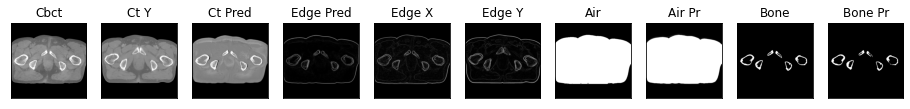

117it [00:43,  2.44it/s]

ssim score = 0.737235963344574
psnr score = 19.59006118774414
snr score = 11.724623680114746
mae error = 0.05006169155240059
air dice score = 0.9955020750736155
bone dice score = 0.9311719372849964
contour dice score = 0.2760121822357178


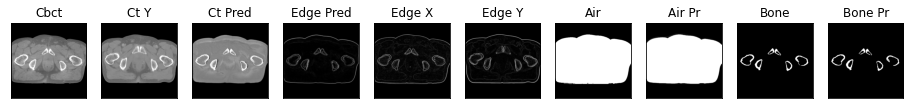

118it [00:43,  2.55it/s]

ssim score = 0.7233593463897705
psnr score = 19.437541961669922
snr score = 11.594714164733887
mae error = 0.05172213912010193
air dice score = 0.9957308278255051
bone dice score = 0.9318415637868848
contour dice score = 0.2646808624267578


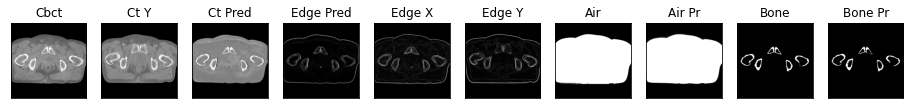

119it [00:44,  2.61it/s]

ssim score = 0.7111034393310547
psnr score = 19.405895233154297
snr score = 11.605844497680664
mae error = 0.05299710854887962
air dice score = 0.996481050253378
bone dice score = 0.9145716377847867
contour dice score = 0.24893435835838318


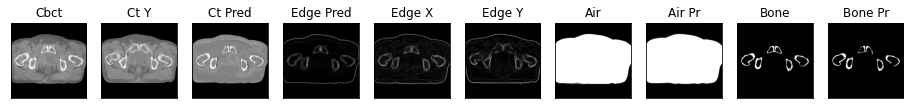

120it [00:44,  2.69it/s]

ssim score = 0.710237979888916
psnr score = 19.457557678222656
snr score = 11.715846061706543
mae error = 0.053213153034448624
air dice score = 0.9962439367230098
bone dice score = 0.9098424757020461
contour dice score = 0.2562471628189087


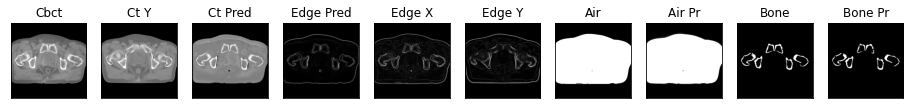

121it [00:45,  2.73it/s]

ssim score = 0.7085662484169006
psnr score = 19.32054328918457
snr score = 11.503459930419922
mae error = 0.05499539151787758
air dice score = 0.9965056502541627
bone dice score = 0.8713332627356631
contour dice score = 0.2511415481567383


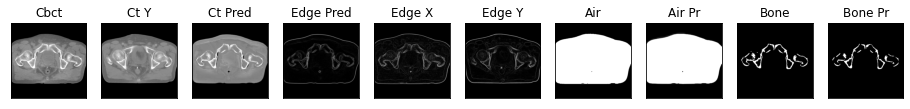

122it [00:45,  2.78it/s]

ssim score = 0.7217093706130981
psnr score = 19.410568237304688
snr score = 11.48626708984375
mae error = 0.054609883576631546
air dice score = 0.99654676258993
bone dice score = 0.8521903561313983
contour dice score = 0.24839596450328827


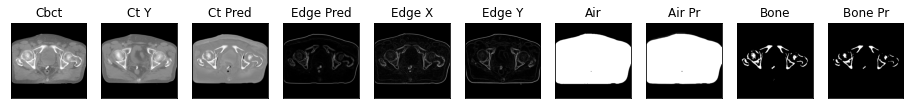

123it [00:45,  2.81it/s]

ssim score = 0.7314854860305786
psnr score = 19.652956008911133
snr score = 11.605568885803223
mae error = 0.05385906994342804
air dice score = 0.9967216515040667
bone dice score = 0.8398709811690783
contour dice score = 0.24367816746234894


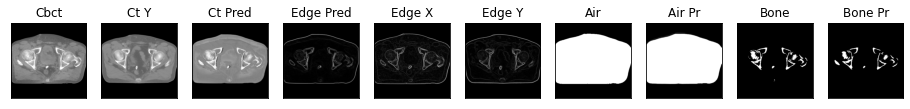

124it [00:46,  2.82it/s]

ssim score = 0.7326857447624207
psnr score = 19.67830467224121
snr score = 11.518484115600586
mae error = 0.05431818589568138
air dice score = 0.9968404697129871
bone dice score = 0.8838292915399362
contour dice score = 0.23763291537761688


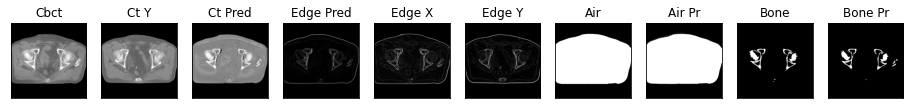

125it [00:46,  2.82it/s]

ssim score = 0.7305187582969666
psnr score = 19.663036346435547
snr score = 11.452569961547852
mae error = 0.05407314375042915
air dice score = 0.996726933571236
bone dice score = 0.9252433215994487
contour dice score = 0.22108685970306396


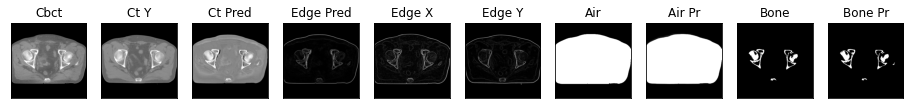

126it [00:46,  2.42it/s]

ssim score = 0.7314525246620178
psnr score = 19.60424041748047
snr score = 11.425928115844727
mae error = 0.05345441773533821
air dice score = 0.9968321136486513
bone dice score = 0.9242208857307357
contour dice score = 0.205032616853714


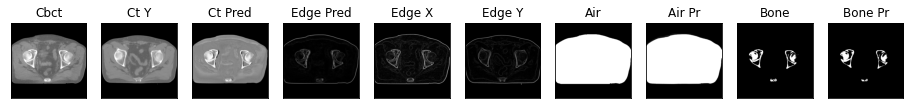

127it [00:47,  2.54it/s]

ssim score = 0.72987961769104
psnr score = 19.563295364379883
snr score = 11.398459434509277
mae error = 0.053081341087818146
air dice score = 0.9967086450588845
bone dice score = 0.929610238511581
contour dice score = 0.19681349396705627


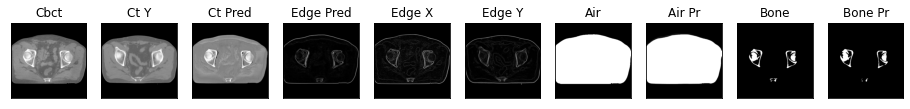

128it [00:47,  2.63it/s]

ssim score = 0.7296435832977295
psnr score = 19.178197860717773
snr score = 10.871872901916504
mae error = 0.0556819848716259
air dice score = 0.9964622849063377
bone dice score = 0.9353648375201122
contour dice score = 0.1568998098373413


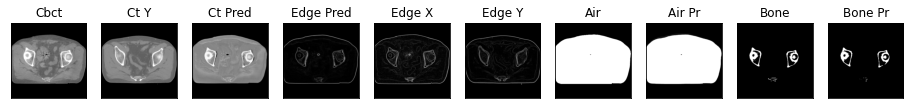

129it [00:48,  2.69it/s]

ssim score = 0.7392647862434387
psnr score = 19.18634605407715
snr score = 10.82071304321289
mae error = 0.05545099824666977
air dice score = 0.9966277959227007
bone dice score = 0.9368752567446683
contour dice score = 0.1609848439693451


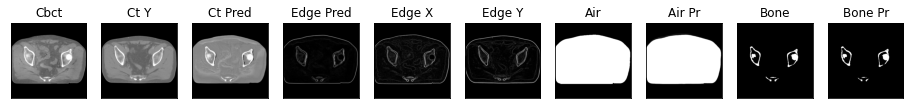

130it [00:48,  2.73it/s]

ssim score = 0.7371968030929565
psnr score = 19.560396194458008
snr score = 11.22041130065918
mae error = 0.051123909652233124
air dice score = 0.9971223873527165
bone dice score = 0.913771377139266
contour dice score = 0.16571970283985138


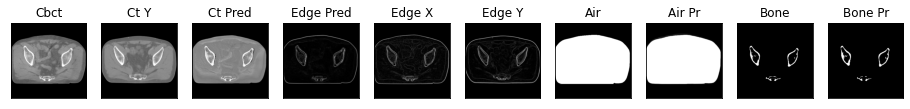

131it [00:48,  2.78it/s]

ssim score = 0.7315081357955933
psnr score = 19.449947357177734
snr score = 11.18277359008789
mae error = 0.05055868625640869
air dice score = 0.9965884531343979
bone dice score = 0.9257417252628067
contour dice score = 0.15442918241024017


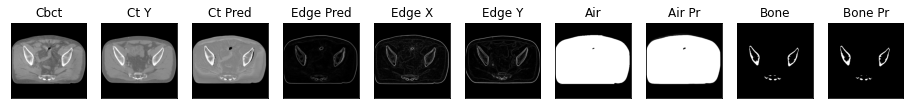

132it [00:49,  2.80it/s]

ssim score = 0.7246804237365723
psnr score = 19.23432159423828
snr score = 11.096376419067383
mae error = 0.051280427724123
air dice score = 0.9967237465485558
bone dice score = 0.93275278181047
contour dice score = 0.17009077966213226


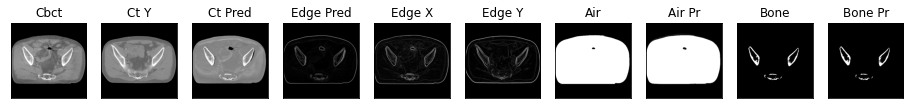

133it [00:49,  2.82it/s]

ssim score = 0.71897953748703
psnr score = 19.099210739135742
snr score = 10.995229721069336
mae error = 0.05236956849694252
air dice score = 0.9965537601368877
bone dice score = 0.9265875994606427
contour dice score = 0.14814814925193787


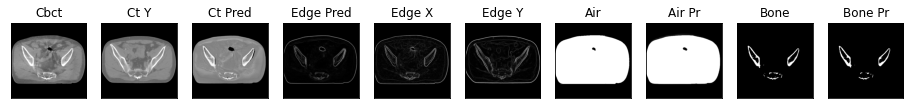

134it [00:49,  2.84it/s]

ssim score = 0.7131917476654053
psnr score = 19.13507080078125
snr score = 11.001296043395996
mae error = 0.05281491577625275
air dice score = 0.9966716802880135
bone dice score = 0.9123470803391052
contour dice score = 0.12246865779161453


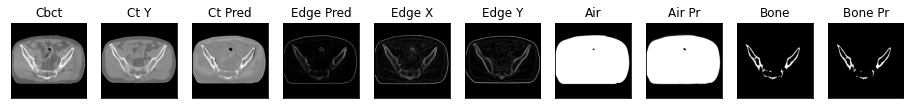

135it [00:50,  2.84it/s]

ssim score = 0.7126721739768982
psnr score = 19.228242874145508
snr score = 11.031094551086426
mae error = 0.05116542801260948
air dice score = 0.9972193109464659
bone dice score = 0.9036678758578037
contour dice score = 0.17294685542583466


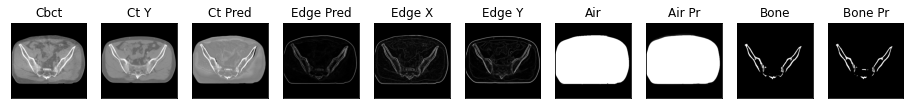

136it [00:50,  2.42it/s]

ssim score = 0.7862806916236877
psnr score = 21.381820678710938
snr score = 12.859212875366211
mae error = 0.038480985909700394
air dice score = 0.9979132475363712
bone dice score = 0.8947965226169233
contour dice score = 0.3019627630710602


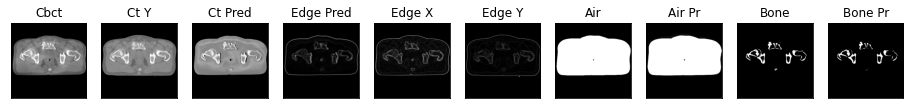

137it [00:51,  2.54it/s]

ssim score = 0.7885755300521851
psnr score = 21.4467716217041
snr score = 12.964174270629883
mae error = 0.038424812257289886
air dice score = 0.998028757819882
bone dice score = 0.894901144642366
contour dice score = 0.27474746108055115


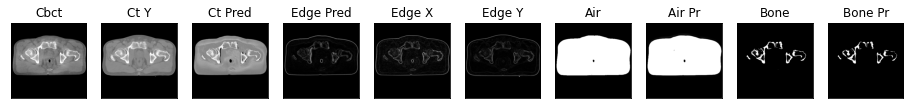

138it [00:51,  2.63it/s]

ssim score = 0.7918533682823181
psnr score = 21.652259826660156
snr score = 13.177450180053711
mae error = 0.037769388407468796
air dice score = 0.9979747740235001
bone dice score = 0.8721517260216652
contour dice score = 0.2722671926021576


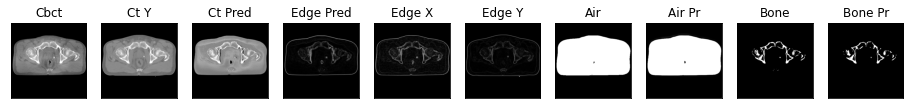

139it [00:51,  2.70it/s]

ssim score = 0.7946285605430603
psnr score = 21.611879348754883
snr score = 13.078649520874023
mae error = 0.03785179182887077
air dice score = 0.9977585846209036
bone dice score = 0.8890851735029769
contour dice score = 0.3028455376625061


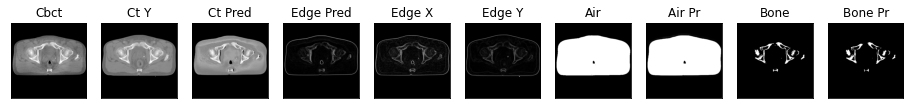

140it [00:52,  2.75it/s]

ssim score = 0.8007152676582336
psnr score = 21.559158325195312
snr score = 12.870304107666016
mae error = 0.03767416626214981
air dice score = 0.9977439833309616
bone dice score = 0.8908666472148984
contour dice score = 0.33571428060531616


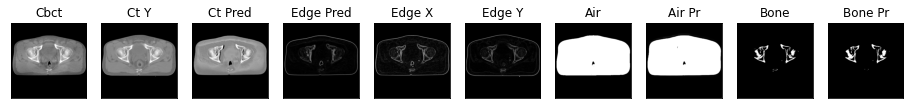

141it [00:52,  2.78it/s]

ssim score = 0.8025545477867126
psnr score = 21.444957733154297
snr score = 12.735300064086914
mae error = 0.03824203833937645
air dice score = 0.9974897787397806
bone dice score = 0.9098913193023814
contour dice score = 0.3480041027069092


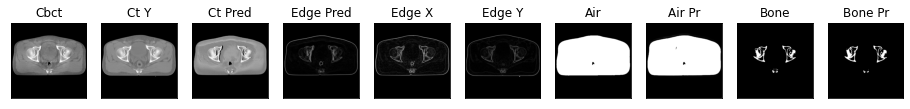

142it [00:52,  2.81it/s]

ssim score = 0.7998476624488831
psnr score = 21.36490821838379
snr score = 12.639619827270508
mae error = 0.03830096498131752
air dice score = 0.9973387613554998
bone dice score = 0.9147695724609277
contour dice score = 0.37435898184776306


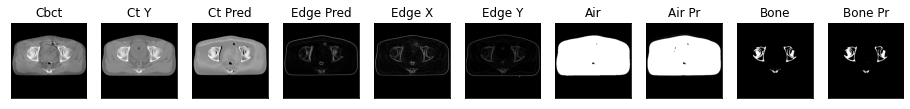

143it [00:53,  2.80it/s]

ssim score = 0.7953351140022278
psnr score = 21.041154861450195
snr score = 12.325233459472656
mae error = 0.039336200803518295
air dice score = 0.9969870397286844
bone dice score = 0.9092422980861887
contour dice score = 0.34226804971694946


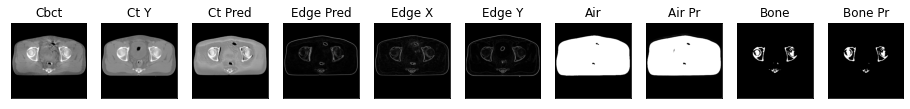

144it [00:53,  2.83it/s]

ssim score = 0.7910467982292175
psnr score = 21.116050720214844
snr score = 12.455910682678223
mae error = 0.03846557438373566
air dice score = 0.997377079006021
bone dice score = 0.9293403256979114
contour dice score = 0.2855664789676666


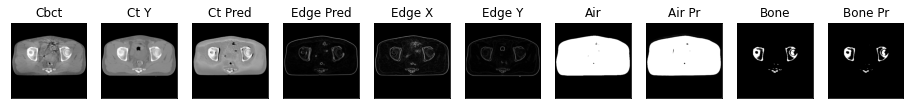

145it [00:54,  2.43it/s]

ssim score = 0.7895750999450684
psnr score = 20.931888580322266
snr score = 12.249814987182617
mae error = 0.03933786600828171
air dice score = 0.9972276805434986
bone dice score = 0.9310246136243414
contour dice score = 0.2735309302806854


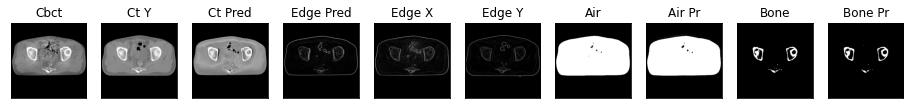

146it [00:54,  2.54it/s]

ssim score = 0.7901355028152466
psnr score = 20.436012268066406
snr score = 11.683168411254883
mae error = 0.04075593873858452
air dice score = 0.9974783366191391
bone dice score = 0.9201746180243191
contour dice score = 0.39874738454818726


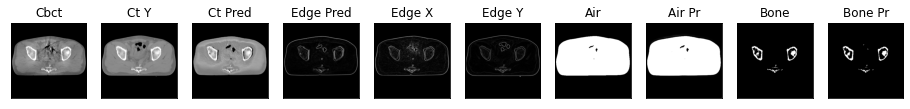

147it [00:54,  2.62it/s]

ssim score = 0.7883739471435547
psnr score = 20.57243537902832
snr score = 11.77569580078125
mae error = 0.04035872966051102
air dice score = 0.9972310187097486
bone dice score = 0.9156111202514293
contour dice score = 0.41697224974632263


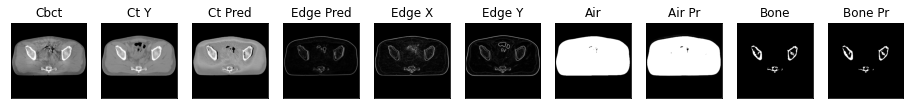

148it [00:55,  2.68it/s]

ssim score = 0.7911173701286316
psnr score = 20.9000301361084
snr score = 12.102192878723145
mae error = 0.03915434703230858
air dice score = 0.9972525785854638
bone dice score = 0.9221344510733172
contour dice score = 0.437894731760025


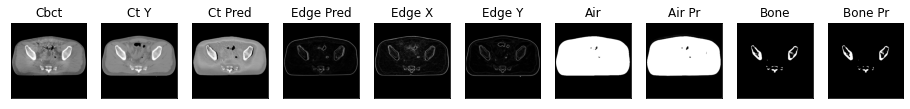

149it [00:55,  2.74it/s]

ssim score = 0.7891731262207031
psnr score = 20.951387405395508
snr score = 12.166910171508789
mae error = 0.03929697349667549
air dice score = 0.9962456153875834
bone dice score = 0.9293087269326039
contour dice score = 0.44514769315719604


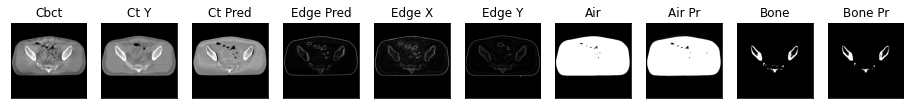

150it [00:55,  2.78it/s]

ssim score = 0.789340615272522
psnr score = 20.955738067626953
snr score = 12.226466178894043
mae error = 0.03949650749564171
air dice score = 0.9964843810497325
bone dice score = 0.9159753813230402
contour dice score = 0.43234673142433167


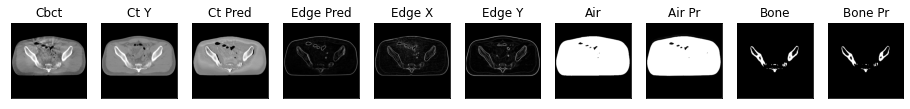

151it [00:56,  2.81it/s]

ssim score = 0.7939626574516296
psnr score = 20.658878326416016
snr score = 11.948974609375
mae error = 0.04012613371014595
air dice score = 0.9960815959155518
bone dice score = 0.9049324882900946
contour dice score = 0.42562201619148254


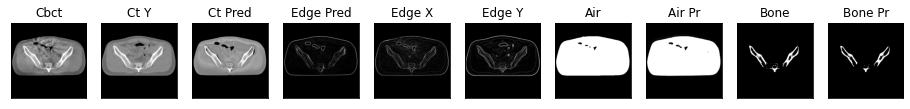

152it [00:56,  2.82it/s]

ssim score = 0.7943598628044128
psnr score = 20.645145416259766
snr score = 11.880502700805664
mae error = 0.03994269669055939
air dice score = 0.9959537393029921
bone dice score = 0.8971962616837681
contour dice score = 0.3855549693107605


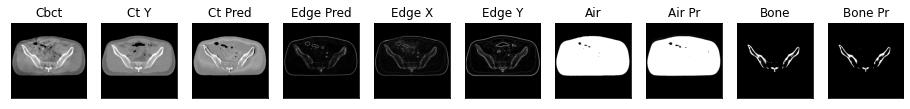

153it [00:56,  2.84it/s]

ssim score = 0.7987754344940186
psnr score = 20.698251724243164
snr score = 11.897254943847656
mae error = 0.039695993065834045
air dice score = 0.9966619939745532
bone dice score = 0.8936359590580977
contour dice score = 0.37593182921409607


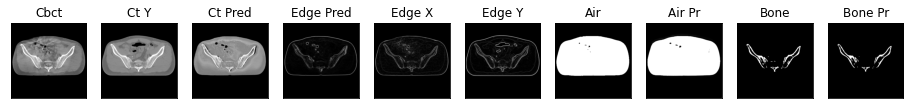

154it [00:57,  2.39it/s]

ssim score = 0.8025410175323486
psnr score = 20.791370391845703
snr score = 11.990446090698242
mae error = 0.03925693780183792
air dice score = 0.9971951899832663
bone dice score = 0.8911024363993659
contour dice score = 0.35331904888153076


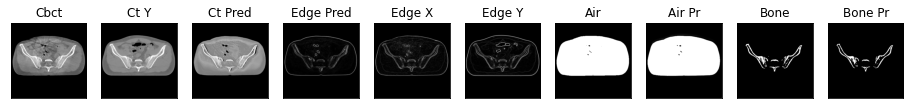

155it [00:57,  2.52it/s]

ssim score = 0.7986888289451599
psnr score = 20.864559173583984
snr score = 12.062214851379395
mae error = 0.03946075215935707
air dice score = 0.9971443647763625
bone dice score = 0.8896068928393968
contour dice score = 0.3698924779891968


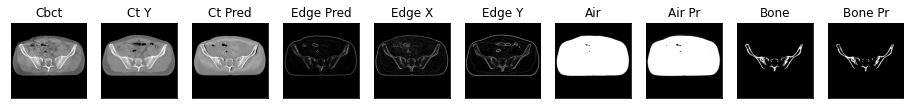

156it [00:58,  2.62it/s]

ssim score = 0.7962521910667419
psnr score = 20.667346954345703
snr score = 11.870039939880371
mae error = 0.04033439978957176
air dice score = 0.9969558007178417
bone dice score = 0.89422558014174
contour dice score = 0.38657280802726746


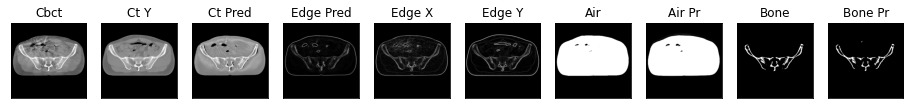

157it [00:58,  2.67it/s]

ssim score = 0.7896364331245422
psnr score = 20.252849578857422
snr score = 11.438270568847656
mae error = 0.042159516364336014
air dice score = 0.995728902656532
bone dice score = 0.8826891671219014
contour dice score = 0.4490463137626648


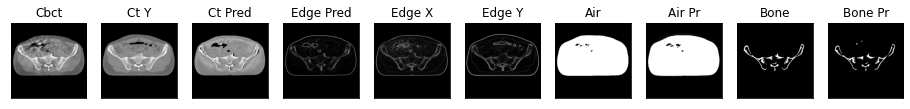

158it [00:58,  2.73it/s]

ssim score = 0.7849593162536621
psnr score = 20.16015625
snr score = 11.326952934265137
mae error = 0.04345608130097389
air dice score = 0.9959081091694515
bone dice score = 0.887430850380967
contour dice score = 0.46238330006599426


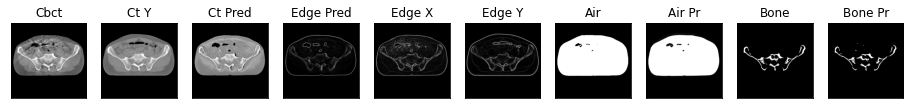

159it [00:59,  2.77it/s]

ssim score = 0.7793523669242859
psnr score = 19.79189109802246
snr score = 10.912747383117676
mae error = 0.04578690603375435
air dice score = 0.9955551352373782
bone dice score = 0.888282703039203
contour dice score = 0.4232044219970703


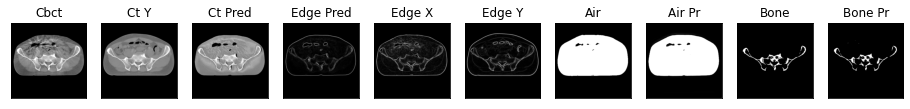

160it [00:59,  2.80it/s]

ssim score = 0.7776934504508972
psnr score = 19.803464889526367
snr score = 10.870524406433105
mae error = 0.046516597270965576
air dice score = 0.9951638818752462
bone dice score = 0.8761433868989352
contour dice score = 0.4055555462837219


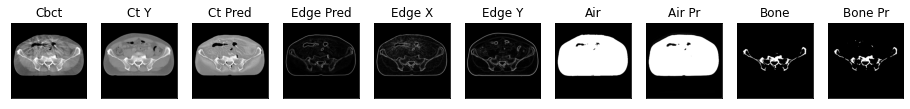

161it [00:59,  2.79it/s]

ssim score = 0.7703671455383301
psnr score = 19.49492835998535
snr score = 10.592452049255371
mae error = 0.049348488450050354
air dice score = 0.9948850122107448
bone dice score = 0.875771795506597
contour dice score = 0.37792640924453735


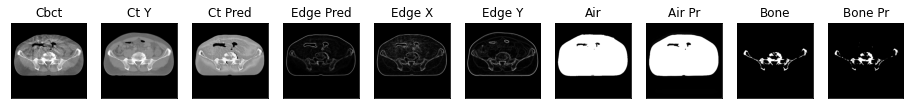

162it [01:00,  2.81it/s]

ssim score = 0.7671423554420471
psnr score = 19.323322296142578
snr score = 10.365620613098145
mae error = 0.05002347379922867
air dice score = 0.9951778612021113
bone dice score = 0.8760689215076443
contour dice score = 0.3808463215827942


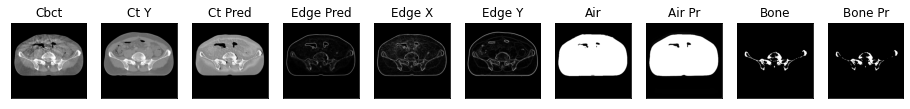

163it [01:00,  2.82it/s]

ssim score = 0.769965648651123
psnr score = 19.727920532226562
snr score = 10.622684478759766
mae error = 0.04810619354248047
air dice score = 0.9960371566399585
bone dice score = 0.8970914308086985
contour dice score = 0.3346390724182129


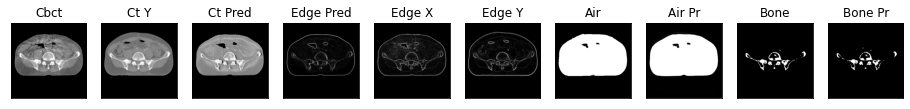

164it [01:01,  2.42it/s]

ssim score = 0.80809086561203
psnr score = 20.97683334350586
snr score = 11.357746124267578
mae error = 0.046299077570438385
air dice score = 0.9956961782358054
bone dice score = 0.9218830832922431
contour dice score = 0.3788759708404541


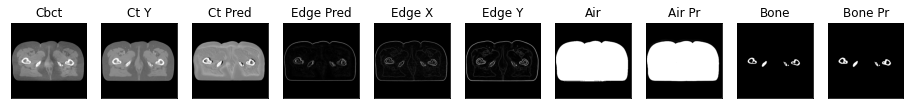

165it [01:01,  2.53it/s]

ssim score = 0.8110752105712891
psnr score = 21.24127960205078
snr score = 11.743203163146973
mae error = 0.045210592448711395
air dice score = 0.996121388088485
bone dice score = 0.9223602484489273
contour dice score = 0.32245302200317383


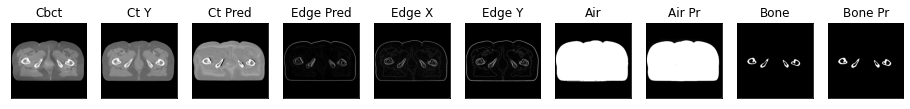

166it [01:01,  2.63it/s]

ssim score = 0.8073375821113586
psnr score = 21.305763244628906
snr score = 11.890603065490723
mae error = 0.0446837916970253
air dice score = 0.9959567260408728
bone dice score = 0.9105011933192024
contour dice score = 0.30987292528152466


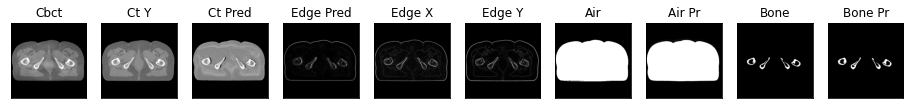

167it [01:02,  2.69it/s]

ssim score = 0.8039191365242004
psnr score = 21.30864906311035
snr score = 11.956934928894043
mae error = 0.044603753834962845
air dice score = 0.9963243556747771
bone dice score = 0.9055132068798881
contour dice score = 0.30092817544937134


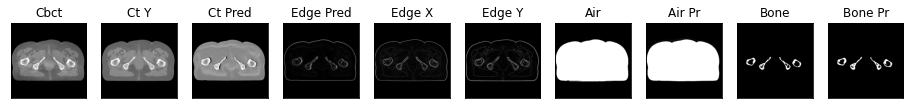

168it [01:02,  2.74it/s]

ssim score = 0.803180456161499
psnr score = 21.26815414428711
snr score = 11.944899559020996
mae error = 0.044806454330682755
air dice score = 0.9961192411924147
bone dice score = 0.926366614934879
contour dice score = 0.29891839623451233


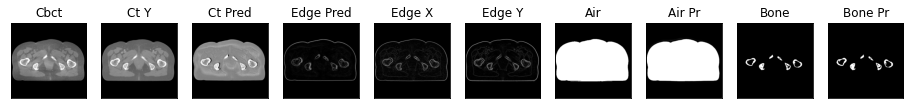

169it [01:02,  2.79it/s]

ssim score = 0.8043619990348816
psnr score = 21.209579467773438
snr score = 11.909280776977539
mae error = 0.04498301073908806
air dice score = 0.9961877995171721
bone dice score = 0.9294307775196726
contour dice score = 0.29113924503326416


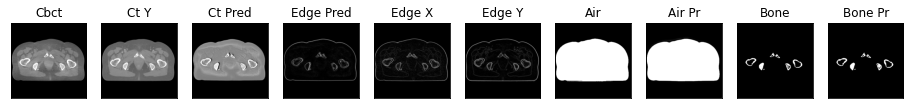

170it [01:03,  2.80it/s]

ssim score = 0.7999125123023987
psnr score = 21.172399520874023
snr score = 11.903428077697754
mae error = 0.04491213336586952
air dice score = 0.9959733666968693
bone dice score = 0.9370008873125644
contour dice score = 0.27272728085517883


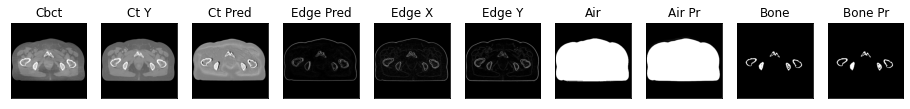

171it [01:03,  2.83it/s]

ssim score = 0.8011967539787292
psnr score = 21.168373107910156
snr score = 11.94776725769043
mae error = 0.04519488662481308
air dice score = 0.9959724605322698
bone dice score = 0.927385892117438
contour dice score = 0.2889411747455597


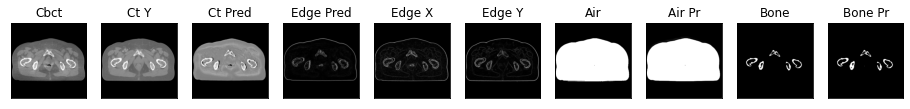

172it [01:03,  2.85it/s]

ssim score = 0.7993597388267517
psnr score = 20.98292350769043
snr score = 11.805062294006348
mae error = 0.04578930884599686
air dice score = 0.9956955712530302
bone dice score = 0.9309952914445365
contour dice score = 0.2857142984867096


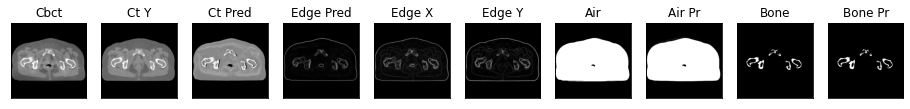

173it [01:04,  2.86it/s]

ssim score = 0.7974938750267029
psnr score = 20.937910079956055
snr score = 11.847748756408691
mae error = 0.0460699088871479
air dice score = 0.9952780353177119
bone dice score = 0.9240000000010857
contour dice score = 0.28464770317077637


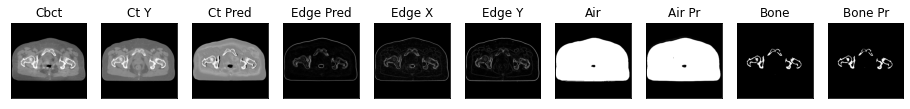

174it [01:04,  2.43it/s]

ssim score = 0.8021569848060608
psnr score = 21.45327377319336
snr score = 12.476383209228516
mae error = 0.04461253061890602
air dice score = 0.9950700849319221
bone dice score = 0.9153340771053015
contour dice score = 0.26235565543174744


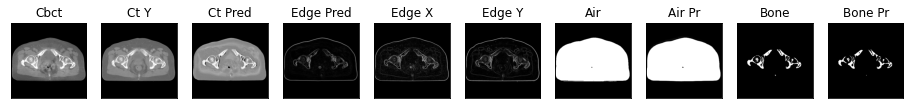

175it [01:05,  2.54it/s]

ssim score = 0.801555871963501
psnr score = 21.05402374267578
snr score = 11.948585510253906
mae error = 0.045984428375959396
air dice score = 0.9952502059676933
bone dice score = 0.8963603721250798
contour dice score = 0.29047179222106934


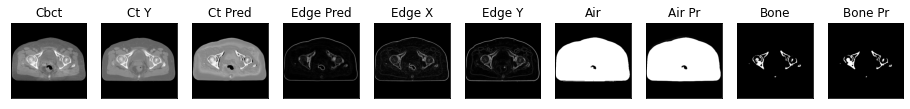

176it [01:05,  2.63it/s]

ssim score = 0.8037521839141846
psnr score = 21.20749282836914
snr score = 11.992631912231445
mae error = 0.04535733535885811
air dice score = 0.994923276312684
bone dice score = 0.8772309356431002
contour dice score = 0.33582788705825806


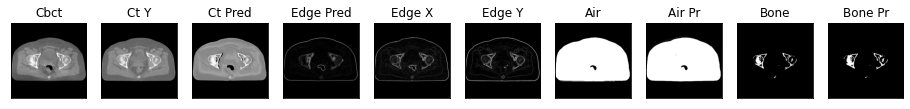

177it [01:05,  2.71it/s]

ssim score = 0.805394172668457
psnr score = 21.02574920654297
snr score = 11.783760070800781
mae error = 0.046477433294057846
air dice score = 0.9948096268214535
bone dice score = 0.9087295014094959
contour dice score = 0.3091742992401123


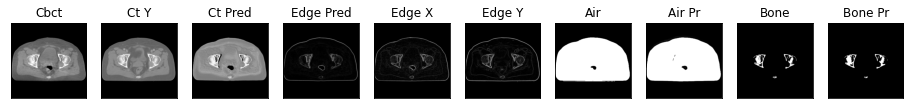

178it [01:06,  2.76it/s]

ssim score = 0.8097584247589111
psnr score = 21.16360092163086
snr score = 11.913609504699707
mae error = 0.0467904694378376
air dice score = 0.9950089555620093
bone dice score = 0.921221864953035
contour dice score = 0.3199251592159271


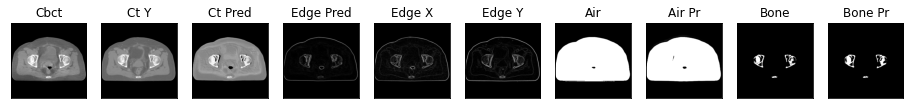

179it [01:06,  2.79it/s]

ssim score = 0.8069170117378235
psnr score = 21.395183563232422
snr score = 12.179417610168457
mae error = 0.0466640330851078
air dice score = 0.9955712771706738
bone dice score = 0.932563221980447
contour dice score = 0.30522844195365906


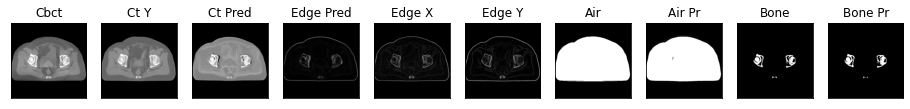

180it [01:06,  2.82it/s]

ssim score = 0.801880419254303
psnr score = 21.02483558654785
snr score = 11.86056137084961
mae error = 0.04826030135154724
air dice score = 0.9962376154843051
bone dice score = 0.9448464383350241
contour dice score = 0.30924856662750244


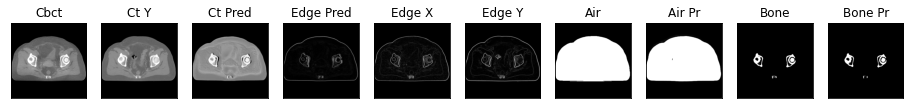

181it [01:07,  2.83it/s]

ssim score = 0.795039176940918
psnr score = 20.642723083496094
snr score = 11.516010284423828
mae error = 0.04911254718899727
air dice score = 0.9964620848823253
bone dice score = 0.9422054536110066
contour dice score = 0.31446540355682373


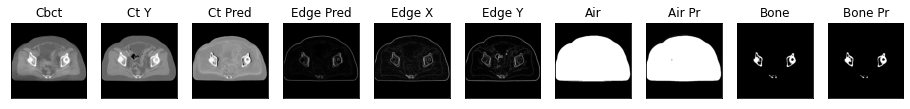

182it [01:07,  2.82it/s]

ssim score = 0.7798295021057129
psnr score = 19.947593688964844
snr score = 10.748442649841309
mae error = 0.0517582967877388
air dice score = 0.9960446671556591
bone dice score = 0.8962743437786563
contour dice score = 0.3281096816062927


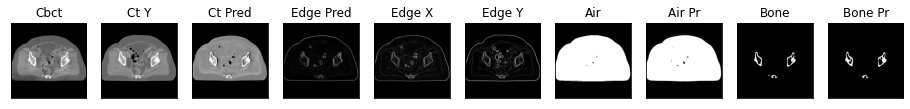

183it [01:08,  2.43it/s]

ssim score = 0.773272693157196
psnr score = 19.8527774810791
snr score = 10.63563346862793
mae error = 0.05284150317311287
air dice score = 0.9958797767985075
bone dice score = 0.9262702702718644
contour dice score = 0.3176645338535309


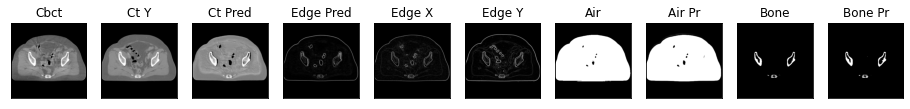

184it [01:08,  2.55it/s]

ssim score = 0.7716693878173828
psnr score = 20.219932556152344
snr score = 11.067704200744629
mae error = 0.05174442380666733
air dice score = 0.9958957742675875
bone dice score = 0.9264123410480214
contour dice score = 0.3094414174556732


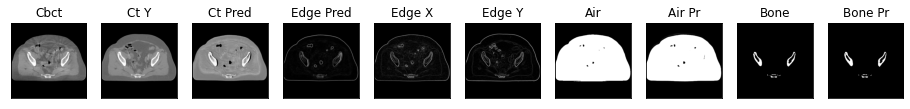

185it [01:08,  2.64it/s]

ssim score = 0.769451379776001
psnr score = 20.21356964111328
snr score = 11.116436004638672
mae error = 0.05258675292134285
air dice score = 0.9952876917722059
bone dice score = 0.9331405854728381
contour dice score = 0.2539840638637543


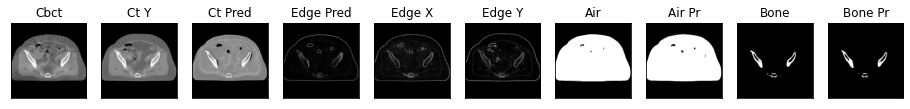

186it [01:09,  2.71it/s]

ssim score = 0.7647743225097656
psnr score = 19.75904655456543
snr score = 10.726341247558594
mae error = 0.054966941475868225
air dice score = 0.9954391779913851
bone dice score = 0.9412841238380161
contour dice score = 0.21796759963035583


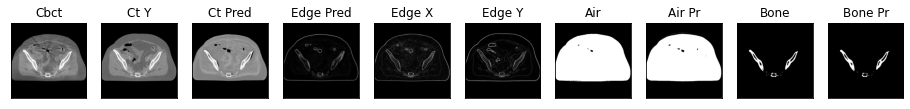

187it [01:09,  2.76it/s]

ssim score = 0.7633740305900574
psnr score = 19.776552200317383
snr score = 10.816706657409668
mae error = 0.0548286996781826
air dice score = 0.9954557112699706
bone dice score = 0.9311448045634839
contour dice score = 0.18953603506088257


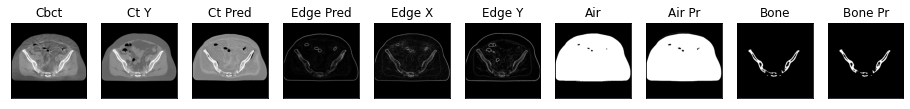

188it [01:09,  2.80it/s]

ssim score = 0.7623421549797058
psnr score = 19.833974838256836
snr score = 10.86983871459961
mae error = 0.055181682109832764
air dice score = 0.9949826775146997
bone dice score = 0.9045747965211258
contour dice score = 0.19070903956890106


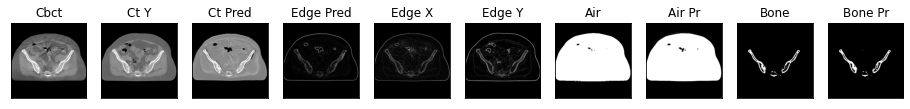

189it [01:10,  2.83it/s]

ssim score = 0.760666012763977
psnr score = 19.843929290771484
snr score = 10.85761547088623
mae error = 0.05602914094924927
air dice score = 0.995775903272063
bone dice score = 0.9134093376776139
contour dice score = 0.16715256869792938


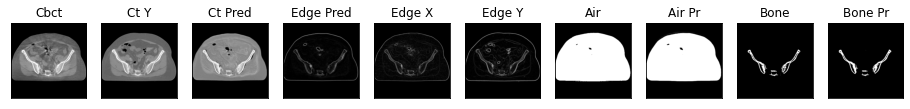

190it [01:10,  2.84it/s]

ssim score = 0.7674078941345215
psnr score = 20.328704833984375
snr score = 11.354026794433594
mae error = 0.05401571840047836
air dice score = 0.9962950402170528
bone dice score = 0.9113314447604627
contour dice score = 0.16698841750621796


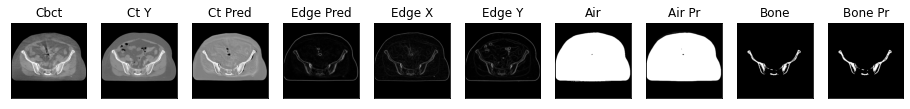

191it [01:11,  2.69it/s]


In [42]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [43]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [44]:
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [45]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:04, 42.73it/s]


(0.7968774824866449,
 20.93210726633122,
 11.936379113122431,
 0.04219984869760369,
 0.995628021100045,
 0.9096509704121547,
 0.3759803588243679,
 0.4476439790575916,
 0.5)

In [46]:
# import torchvision.models as models
# models.vgg16(pretrained=True)